# Setup

## Import packages

In [67]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from neuprint import skeleton as npskel
from cloudvolume import Skeleton
from io import StringIO
import networkx as nx
import re
from tqdm import tqdm

In [2]:
import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/eCREST/eCREST')

In [3]:
# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [495]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

def skeleton_swc_to_df(swc):
    """
    Create a DataFrame from and SWC file.
    The 'node_type' column is discarded.

    Args:
        swc:
            Either a filepath ending in '.swc', or a file object,
            or the contents of an SWC file (as a string).

    Returns:
        ``pd.DataFrame``
    """
    if hasattr(swc, 'read'):
        swc = swc.read()
    else:
        assert isinstance(swc, str)
        if swc.endswith('.swc'):
            with open(swc, 'r') as f:
                swc = f.read()

    cols = ['rowId', 'node_type', 'x', 'y', 'z', 'radius', 'link']
    lines = swc.split('\n')
    lines = filter(lambda line: '#' not in line, lines)
    swc_csv = '\n'.join(lines)

    # Compact dtypes save RAM when loading lots of skeletons
    dtypes = {
        'rowId': np.int32,
        'node_type': np.int8,
        'x': np.float32,
        'y': np.float32,
        'z': np.float32,
        'radius': np.float32,
        'link': np.int32,
    }
    df = pd.read_csv(StringIO(swc_csv), delimiter=' ', engine='c', names=cols, dtype=dtypes, header=None)
    # df = df.drop(columns=['node_type'])
    return df


def find_closest_row(df, target_coords, multipliers=(128, 128, 120)):
    """
    Finds the row in the dataframe closest to the target coordinates after scaling.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'x', 'y', 'z', and 'rowId' columns.
        target_coords (tuple): Target coordinates (x, y, z) in original units.
        multipliers (tuple): Scaling factors for the coordinates (default is (16, 16, 30)).

    Returns:
        pd.Series: The row with the closest coordinates, including the rowId.
    """
    # Scale the target coordinates
    target_scaled = tuple(coord * multiplier for coord, multiplier in zip(target_coords, multipliers))
    
    # Calculate Euclidean distance to the target for each row
    df['distance'] = np.sqrt(
        (df['x'] - target_scaled[0])**2 +
        (df['y'] - target_scaled[1])**2 +
        (df['z'] - target_scaled[2])**2
    )
    
    # Find the closest row
    closest_row = df.loc[df['distance'].idxmin()]
    
    return closest_row #int(closest_row['rowId'])

def find_downstream_nodes_exclude_root(G, start_node, root_node):
    """
    Finds all downstream nodes from a given node, excluding those with paths containing the root node.

    Parameters:
        G (networkx.DiGraph): The directed graph.
        start_node (int): The node ID to start the search from.
        root_node (int): The root node to exclude from paths.

    Returns:
        list: A list of downstream node IDs that do not contain the root node in their paths.
    """
    if not G.has_node(start_node):
        raise ValueError(f"Start node {start_node} does not exist in the graph.")
    if not G.has_node(root_node):
        raise ValueError(f"Root node {root_node} does not exist in the graph.")
    
    # Perform depth-first search to find all reachable nodes
    all_downstream_nodes = list(nx.dfs_preorder_nodes(G, source=start_node))
    
    # Filter out nodes that have a path passing through the root node
    valid_nodes = []
    for node in all_downstream_nodes:
        if node == start_node:
            continue  # Skip the starting node itself
        paths_to_node = nx.all_simple_paths(G, source=start_node, target=node)
        # Check if any path includes the root node
        if not any(root_node in path for path in paths_to_node):
            valid_nodes.append(node)
    
    return valid_nodes

def find_downstream_nodes_all_paths_exclude_root(G, start_node, root_node, terminal_nodes):
    """
    Finds all nodes downstream of a given node in all paths, excluding those with paths containing the root node.

    Parameters:
        G (networkx.DiGraph): The directed graph.
        start_node (int): The node ID to start the search from.
        root_node (int): The root node to exclude from paths.

    Returns:
        list: A list of all downstream node IDs that do not contain the root node in their paths.
    """
    if not G.has_node(start_node):
        raise ValueError(f"Start node {start_node} does not exist in the graph.")
    if not G.has_node(root_node):
        raise ValueError(f"Root node {root_node} does not exist in the graph.")
    
    # List to store valid downstream nodes
    valid_downstream_nodes = set()

    valid_downstream_nodes = set()
    # Iterate through all nodes in the graph to find paths from start_node
    with tqdm(total=len(terminal_nodes)) as pbar:
        for node in terminal_nodes: #G.nodes:
            pbar.update(1)
            # Get all simple paths from start_node to node (if reachable)
            for path in nx.all_simple_paths(G, source=start_node, target=node):
                # If the path does not contain the root node, add the target node
                if root_node not in path:
                    # valid_downstream_nodes.add(node)
                    valid_downstream_nodes.update(path)
                    break  # No need to check further paths to this node, since we found a valid one

    return list(valid_downstream_nodes)


def find_terminal_nodes(G):
    """
    Finds all terminal nodes in a directed graph (nodes with no outgoing edges).
    
    Parameters:
        G (networkx.DiGraph): The directed graph.
    
    Returns:
        list: A list of terminal node IDs (nodes with no outgoing edges).
    """
    return [node for node in G.nodes() if G.out_degree(node) == 0]



from collections import defaultdict

# def to_swc(self, contributors=""):

def render_row(row):
  return "{n} {T} {x:0.6f} {y:0.6f} {z:0.6f} {R:0.6f} {P}".format(
    n=row[0],
    T=row[1],
    x=row[2],
    y=row[3],
    z=row[4],
    R=row[5],
    P=row[6],
  )

# skels = self.components()
def renumber(rows):
  mapping = { -1: -1 }
  N = 1
  for row in rows:
    node = row[0]
    if node in mapping:
      row[0] = mapping[node]
      continue
    else:
      row[0] = N
      mapping[node] = N
      N += 1

  for row in rows:
    row[-1] = mapping[row[-1]]

  return rows

In [245]:
def df_to_swc_cloudvolume(df, swc_outpath, filename):
    
    #### initialize swc string
    
    """
    Prototype SWC file generator. 
    The SWC format was first defined in 
    
    R.C Cannona, D.A Turner, G.K Pyapali, H.V Wheal. 
    "An on-line archive of reconstructed hippocampal neurons".
    Journal of Neuroscience Methods
    Volume 84, Issues 1-2, 1 October 1998, Pages 49-54
    doi: 10.1016/S0165-0270(98)00091-0
    This website is also helpful for understanding the format:
    https://web.archive.org/web/20180423163403/http://research.mssm.edu/cnic/swc.html
    Returns: swc as a string
    """
    # from cloudvolume import __version__
    # sx, sy, sz = np.diag(self.transform)[:3]
    swc_header = f"""# ORIGINAL_SOURCE CloudVolume modified scripts 11.1.1
    # CREATURE 
    # REGION
    # FIELD/LAYER
    # TYPE
    # CONTRIBUTOR kperks
    # REFERENCE
    # RAW 
    # EXTRAS 
    # SOMA_AREA
    # SHINKAGE_CORRECTION 
    # SCALE don't know how to get from dataframe yet 
    """
    # VERSION_DATE {datetime.datetime.utcnow().isoformat()}
    #SCALE {sx:.6f} {sy:.6f} {sz:.6f}
    
    # skels = skel.components()
    swc = swc_header + "\n"
    offset = 0
    # for skel in skels:
    #   swc += generate_swc(skel, offset) + "\n"
    
    ### extract rows to list from DataFrame
    
    all_rows = []
    # Iterate over each row
    for index, r in df.iterrows():
        # Create list for the current row
        row_list =[int(r.rowId), int(r.node_type), r.x, r.y, r.z, r.radius, int(r.link)]
        # append the list to the final list
        all_rows.append(row_list)
    
    ### renumber rows needed due to root node change
    
    all_rows = renumber(all_rows)
    
    ### add rows to swc string
    
    swc += "\n".join((
      render_row(row)
      for row in all_rows
    ))
    
    # return swc
    
    #### CloudVolume Skeleton from swc string
    
    # skel = Skeleton.from_swc(skelfile_labeled)
    
    lines = swc.split("\n")
    
    while len(lines) and (lines[0] == '' or re.match(r'[#\s]', lines[0][0])):
      l = lines.pop(0)
    
    if len(lines) == 0:
      # return Skeleton()
        skel_fromswc = Skeleton()
    
    vertices = []
    edges = []
    radii = []
    vertex_types = []
    
    label_index = {}
    
    N = 0
    
    for line in lines:
      if line.replace(r"\s", '') == '':
        continue
      (vid, vtype, x, y, z, radius, parent_id) = line.split(" ")
      
      coord = tuple([ float(_) for _ in (x,y,z) ])
      vid = int(vid)
      parent_id = int(parent_id)
    
      label_index[vid] = N
    
      if parent_id >= 0:
        if vid < parent_id:
          edge = [vid, parent_id]
        else:
          edge = [parent_id, vid]
    
        edges.append(edge)
    
      vertices.append(coord)
      vertex_types.append(int(vtype))
    
      try:
        radius = float(radius)
      except ValueError:
        radius = -1 # e.g. radius = NA or N/A
    
      radii.append(radius)
    
      N += 1
    
    for edge in edges:
      edge[0] = label_index[edge[0]]
      edge[1] = label_index[edge[1]]
    
    skel_fromswc = Skeleton(vertices, edges, radii, vertex_types)
    
    #### export swc from Skeleton
    
    # swc_outpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc')
    
    # filename = cell_folder + '_chopped_labeled.swc'
    
    # Step 4: Write the SWC data to a file
    with open(swc_outpath / filename, 'w') as swc_file:
        swc_file.write(skel_fromswc.to_swc())

## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [5]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [6]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [7]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [8]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome')

In [9]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [10]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]


# Load files

## mg_network file names

In [636]:
dirpath = Path(settings_dict['save_dir'])


In [637]:
nodefiles = get_cell_filepaths(dirpath)

In [638]:
len(nodefiles)

5812

## df_syn pre or post

In [922]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn_mg_output.csv')
syn = 'pre-synaptic'

In [923]:
len(df_syn)

6674

In [924]:
df_syn = df_syn.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})
df_syn

,Unnamed: 0,post,pre,structure,x,y,z
0,0,126649726,305329558,axon,333376,306304,50700
1,1,126649726,221714230,axon,341472,295248,37110
2,2,126649726,302730452,axon,229456,307280,52860
3,3,126649726,44244249,axon,337200,270496,19050
4,4,126649726,559551706,axon,322752,307680,65130
...,...,...,...,...,...,...,...
6669,6669,479001172,650797651,unknown,188272,310992,85500
6670,6670,479001172,62356413,unknown,190384,325984,63300
6671,6671,479001172,397737711,unknown,192416,336864,67650
6672,6672,479001172,484725497,unknown,179536,339984,79080


In [925]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

# cell types for all files in directory

## from file

In [926]:
df_type = pd.read_csv(dirpath / 'metadata/df_type.csv')

## manual type

In [15]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [16]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [17]:
df_type_auto.dropna(inplace=True)

In [18]:
df_type_auto.head()

,id,cell_type
98,127607174,mg2
100,127672247,mg2
148,129572524,mg1
724,213501262,mg1
749,214440956,mg2


## combine manual and auto df_type

In [19]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [20]:
df_type.head()

,id,cell_type
0,102463116,pf
1,103366246,uk
2,103549879,mli
3,109461049,fov
4,109502641,mli


In [154]:
df_type[df_type['cell_type'].isin(['sg1','sg2'])]

,Unnamed: 0,id,cell_type
100,100,127641472,sg1
104,104,127700739,sg2
109,109,127838393,sg1
111,111,127857293,sg1
121,121,128614407,sg1
...,...,...,...
5276,5276,649497765,sg2
5283,5283,649572893,sg2
5295,5295,649805291,sg2
5312,5312,650501012,sg2


# add cell type to df_syn

In [927]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

# df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
# df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [47]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2


# filter df_syn

## include only classic mg2 for main analysis

In [740]:
mg2_post_classic = [[386426114, 214581797, 213605530, 126649726, 299404889]]
mg2_post_spectrum = [385434515,386392158,221746236,215492896,387850816,216129202,300226567] 
df_syn = df_syn[~df_syn['post'].isin(mg2_post_spectrum)]

## subselect post_syn types to include

In [21]:
df_syn = df_syn[df_syn['post_type'].isin(['mg1','mg2','lg','lf','sg1','sg2','grc','smpl'])]

In [22]:
df_syn['post_type'].unique()

array(['mg2', 'sg1', 'grc', 'sg2', 'smpl', 'mg1', 'lg', 'lf'],
      dtype=object)

## save filtered df_syn

In [34]:
savepath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/graphs')

df_syn = df_syn.drop(['pre_type','post_type'],axis=1)
df_syn.to_csv(savepath / 'df_presyn_filt.csv')

In [194]:
# # include only connections to the following types/groups of cells
# pre_groups = ['mg1','mg2']
# post_groups = ['mg1','mg2','lg','lf']
# df_syn = df_syn[(df_syn['post_type'].isin(post_groups)) & df_syn['pre_type'].isin(pre_groups)]
# len(df_syn)

6196

# shuffle df_syn

In [48]:
df_syn_rand = deepcopy(df_syn)

shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_syn = df_syn_rand

# --> df_edges

In [198]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2
3,3,126618353,394686712,unknown,370.112,314.832,52.62,-54.398373,mg1,lf
5,5,126618353,394686712,basal dendrite,359.792,314.608,51.39,-55.535101,mg1,lf


In [162]:
# remove structure and soma diameter information if want to
# df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [928]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

## probe df_syn and df_edges

### synapse locations to csv for model

In [22]:
mask = df_syn['post'].isin([393325331]) #& df_edges['pre_type'].isin(['aff'])
df_syn[mask].drop(columns=['Unnamed: 0', 'structure']).to_csv('/Users/kperks/Downloads/syn_LF_393325331_nm.csv')

### filter df_edges for counts, etc

In [42]:
mask = df_edges['post'].isin([299496636,214581797,393325331,301787806])  & df_edges['pre_type'].isin(['aff','smpl','grc','sg1','sg2'])
df_edges[mask].groupby(['post','post_type','pre_type'])['pre'].count()#number of presynaptic cells by type
# df_edges[mask].groupby(['post','post_type','pre_type'])['weight'].sum(numeric_only=True)#number of presynaptic synapses by type

post       post_type  pre_type
214581797  mg2        aff           3
                      grc           1
                      sg1          86
                      smpl         13
299496636  mg1        grc          87
                      sg2          57
301787806  lg         grc         123
                      sg2          30
                      smpl          1
393325331  lf         aff           9
                      grc           1
                      sg1          53
                      smpl         20
Name: pre, dtype: int64

In [933]:
mask = df_edges['post'].isin([387850816]) & df_edges['pre_type'].isin(['mg1'])
df_edges[mask]#.groupby(['pre'])['weight'].count()

,pre,post,pre_type,post_type,weight
31,389085521,387850816,mg1,mg2,8
32,386643184,387850816,mg1,mg2,8
211,473723476,387850816,mg1,mg2,5
451,217291581,387850816,mg1,mg2,3
647,558346897,387850816,mg1,mg2,3
1287,126618353,387850816,mg1,mg2,2
1322,127870654,387850816,mg1,mg2,2
1957,647917530,387850816,mg1,mg2,1
2641,302143252,387850816,mg1,mg2,1
2769,214953997,387850816,mg1,mg2,1


In [ ]:
[126618353, 127870654, 214953997, 217291581, 386643184, 389085521,
       473723476, 558346897, 647917530]

In [91]:
mask = df_edges['post'].isin([214581797]) & df_edges['pre_type'].isin(['smpl'])
df_edges[mask]['pre'].values

array([305051491,  47396976, 132158911, 132187244, 305020954, 220290845,
       219146053, 392042360, 131029691,  48542882,  45120720, 305099311,
       219161561])

In [52]:
mask = df_edges['post'].isin([299496636]) & df_edges['pre_type'].isin(['grc'])
grc_pre = df_edges[mask]['pre'].values

mask = df_edges['post'].isin(grc_pre)
df_edges[mask]['post'].unique()

array([397967979, 482680782, 483689146, 142617839, 395461156, 228366816])

In [141]:
mask = df_edges['post_type'].isin(['mg1']) & df_edges['pre_type'].isin(['grc'])
grc_pre_mg1 = df_edges[mask]['pre'].unique()#.groupby(['post','pre']).sum()

mask = df_edges['post_type'].isin(['sg1']) & df_edges['pre_type'].isin(['grc'])
grc_pre_sg1 = df_edges[mask]['pre'].unique()#.groupby(['post','pre']).sum()

mask = df_edges['post_type'].isin(['smpl']) & df_edges['pre_type'].isin(['grc'])
grc_pre_smpl = df_edges[mask]['pre'].unique()#.groupby(['post','pre']).sum()

mask = df_edges['post_type'].isin(['lg']) & df_edges['pre_type'].isin(['grc'])
grc_pre_lg = df_edges[mask]['pre'].unique()#.groupby(['post','pre']).sum()

In [31]:
mask = df_edges['post_type'].isin(['sg2'])
df_edges[mask].groupby(['post','pre_type']).sum(numeric_only=True).head(100)#.reset_index()

pre  weight
post      pre_type                    
50786130  aff       1561037314      35
          fov       2335372842      14
          h          622527144       2
          sg1       2639441316      20
          sgx1       822148256       4
...                        ...     ...
647514445 aff       2065502583      19
          fov       5023100995      20
          sg1       5864809200      36
          sgx1      1686020191      10
          smpl       306338104       2

[87 rows x 2 columns]

In [23]:
df_edges[mask]['post'].unique()

array([389891998,  50786130, 393433572, 306461085, 647514445, 218095913,
       387415866, 394423863, 477962738, 395507584, 473491444])

In [656]:
mask = df_edges['post_type'].isin(['mg1']) #& df_edges['pre_type'].isin(['aff'])
df_edges[mask]['post'].unique()

array([299439953, 386224676, 299405462, 299496636, 299392199])

# Completeness of synapses



In [647]:
syn = 'pre-synaptic'

In [648]:
df_edges['pre_type'].unique()

array(['aff', 'sg2', 'mg1', 'sg1', 'fov', 'mg2', 'sgx1', 'smpl', 'sgx2',
       'grc', 'pe', 'mli', 'uk', 'h', 'pf', 'tsd', 'glia', 'lf', 'lg'],
      dtype=object)

In [649]:
all_types = set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','cell_type','n_syn','done','todo','completed']) #'soma-diam',
for c in df_edges['post'].unique():
    
    if (df_edges[df_edges['post'] == c]['post_type'].unique()[0] in c_type_check):

        c_df = df_edges[df_edges['post'].isin([c])]
        n_syn_done = c_df['weight'].sum()

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)
        
        if len(cell.cell_data['end_points'][syn])>0:
            # try:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'cell_type': df_type[df_type['id']==c]['cell_type'].values[0],#cell_type[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': len(cell.cell_data['end_points'][syn]),
                'done': n_syn_done, #len(c_df),
                'todo': len(cell.cell_data['end_points'][syn]) - n_syn_done, #len(c_df),
                'completed': n_syn_done / (len(cell.cell_data['end_points'][syn]))
                }
            # except:
            #     print(f'error on {c}')
            #     continue
        
        if len(cell.cell_data['end_points'][syn])==0:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'cell_type': df_type[df_type['id']==c]['cell_type'].values[0],#cell_type[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': np.NaN,
                'done': n_syn_done, #len(c_df),
                'todo': np.NaN, #len(c_df),
                'completed': np.NaN
                }
            # print(f'error on {c}')
            # continue

        cell_df = pd.DataFrame([cell_dict]).dropna(how='all')
        if not cell_df.empty:
            df_progress = pd.concat([df_progress, cell_df], ignore_index=True)

        # df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

In [655]:
df_progress[(df_progress['cell_type'].isin(['lf','lg']))].sort_values('todo')# & (df_progress['todo']>0) #grc','sgx2','sg2','mg2

,id,cell_type,n_syn,done,todo,completed
13,393325331,lf,572,574,-2,1.003497
14,303969144,lg,98,98,0,1.000000
19,307418797,lf,354,354,0,1.000000
21,392072123,lf,326,326,0,1.000000
29,301727988,lg,203,203,0,1.000000
34,300474334,lg,381,381,0,1.000000
7,301787806,lg,541,540,1,0.998152
31,472392041,lg,392,391,1,0.997449
40,393078033,lf,180,179,1,0.994444
57,479001172,lf,173,172,1,0.994220


# Color Palette

In [64]:
syn_colors = {
    'sgx1':'#B2D732', #'#996633',
    'sgx2':'#FCCC1A',
    'sg1':'#B2D732',
    'sg2':'#FCCC1A',
    'grc':'#FEFE33',
    'smpl':'#8601AF',
    'dml':'#cccccc',
    'mg1':'#00CBFF',#'#347C98',#'#357D99',#'#80DBFF',##'#0000ff',
    'mg2':'#FB9902',#'#ff0000',
    'lf':'#FE2712',#'#8000c8',
    'lg':'#0247FE',#'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'mli':"000000",
    # 'uk':,
    # 'fov':,
    'h':'#666666'
}

# synapses locations in df_syn

## absolute

In [44]:
df_syn['depth'] = pd.cut(df_syn['y_adj'], bins=np.arange(-100,20,5))

In [45]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type,depth
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2,"(-50, -45]"
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2,"(-45, -40]"
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2,"(-55, -50]"
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2,"(-20, -15]"
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2,"(-50, -45]"


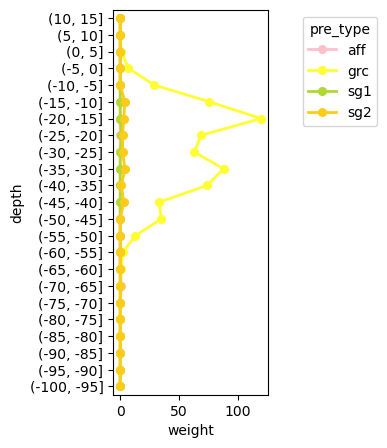

In [60]:
# mask = df_syn['post_type'].isin(['mg1']) & df_syn['pre_type'].isin(['grc','sg2','mg2'])
post_target = 'sg1'
mask = df_syn['post_type'].isin([post_target]) & df_syn['pre_type'].isin(['aff','smpl','sg1','grc','sg2'])

df_grouped = df_syn[mask][['post','pre_type','depth']].groupby(['depth','pre_type'],observed=False).count().reset_index()
df_grouped.rename(columns={'post':'weight'},inplace=True)

df_grouped.loc[df_grouped['pre_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_grouped.loc[df_grouped['pre_type'].isin(['mg1','mg2']),'class'] = 'mg'
df_grouped.loc[df_grouped['pre_type'].isin(['lf','lg']),'class'] = 'output'
df_grouped.loc[df_grouped['pre_type'].isin(['mli','tsd','dml','h']),'class'] = 'smooth'
df_grouped.loc[df_grouped['pre_type'].isin(['grc','smpl']),'class'] = 'small'
df_grouped.loc[df_grouped['pre_type'].isin(['aff']),'class'] = 'afferent'

df_grouped['weight_norm'] = df_grouped.groupby('depth',observed=False)['weight'].transform(lambda x: (x / x.sum()) )

df_grouped['weight_all'] = df_grouped.groupby('depth',observed=False)['weight'].transform(lambda x: (x.sum()) )


# Create a seaborn plot
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight',hue = 'pre_type',palette=syn_colors,linewidth=2)#,order = ['lg','mg1','sg1','lf','mg2','sg2'])
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.75, 1));
# plt.savefig('/Users/kperks/Downloads/mg1_pre_synapse_locations_binned.svg',transparent=True) 
plt.savefig(f'/Users/kperks/Downloads/{post_target}_pre_synapse_locations_binned.png',transparent=True) 

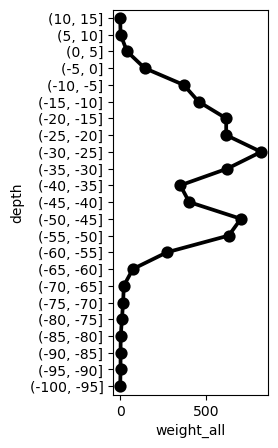

In [230]:
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight_all',color='black')
ax.invert_yaxis()

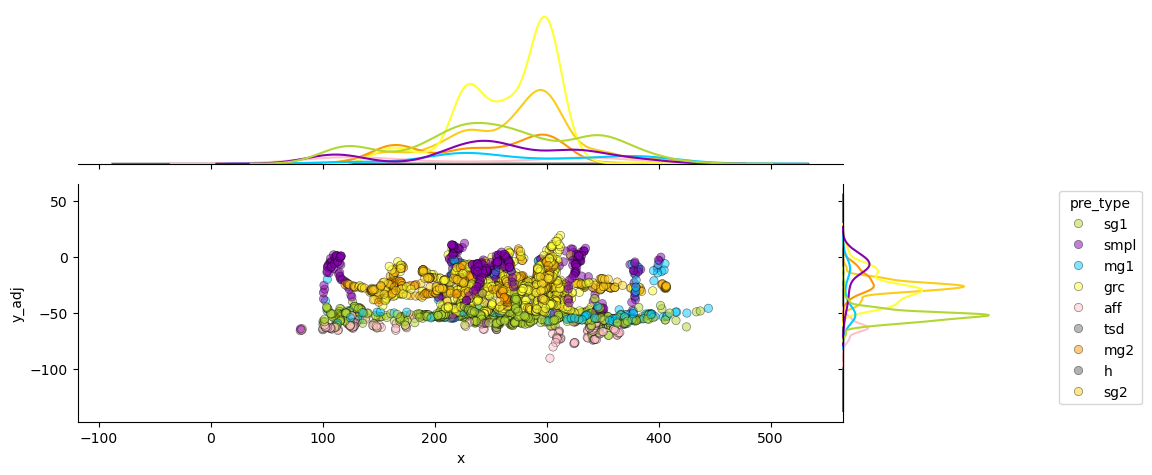

In [22]:
mask = df_syn['post_type'].isin(['mg2','mg1','lg']) & df_syn['pre_type'].isin(['aff','grc','smpl','sg1','sg2','mg1','mg2','tsd','h'])
g = sns.jointplot(data=df_syn[mask], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

## Biophysical distances

### chop extraneous

### swc to DataFrame

In [871]:
skelpath = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc/'
cell_folder = 'mg2_386426114_mip3' #sg2_387415866_crude_mip3.swc'

In [872]:
# df = npskel.skeleton_swc_to_df(f'{skelfile}{cell_folder}.swc')
df = skeleton_swc_to_df(f'{skelpath}{cell_folder}.swc')


In [873]:
coord_root = (16253, 16365, 2182)
multipliers = (16,16,30)
npskel.reorient_skeleton(df,xyz=tuple(coord * multiplier for coord, multiplier in zip(coord_root, multipliers)))

In [874]:
df.head()

,rowId,node_type,x,y,z,radius,link
0,1,0,145216.0,287040.0,10620.0,120.0,2
1,2,0,145344.0,287040.0,10740.0,120.0,3
2,3,0,145472.0,287040.0,10860.0,120.0,4
3,4,0,145472.0,287040.0,10980.0,128.0,5
4,5,0,145600.0,287040.0,11100.0,120.0,6


### df to iGraph to find nodes in paths without root

In [875]:
df_chopped = deepcopy(df)

G = npskel.skeleton_df_to_nx(df_chopped, with_attributes=True, directed=True, with_distances=True, virtual_roots=False)
G = G.reverse()

terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

In [876]:
df_chopped[df_chopped['link'].isin([-1])]

,rowId,node_type,x,y,z,radius,link
6055,6056,0,259904.0,261824.0,65460.0,5442.922852,-1


In [877]:

root_node = df_chopped[df_chopped['link'].isin([-1])]['rowId'].values[0]
target_coords =[(16125, 15905, 2648),(16399, 15634, 1969)]

valid_nodes_all = []
for coords in target_coords:
    closest_row = find_closest_row(df_chopped, coords, multipliers = (16,16,30))

    start_node = int(closest_row['rowId'])  # Replace with your starting node
    valid_downstream_nodes = find_downstream_nodes_all_paths_exclude_root(G, start_node, root_node,terminal_nodes)
    valid_nodes_all.extend(valid_downstream_nodes)

# print(f"Valid downstream nodes from {start_node} (excluding paths through root {root_node}): {valid_downstream_nodes}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1022/1022 [04:37<00:00,  3.69it/s]


In [543]:
# valid_nodes_all

In [888]:
# Extract the subgraph for the branch
branch_subgraph = G.subgraph(valid_nodes_all)

pos = {node: (branch_subgraph.nodes[node]['x'], -1*branch_subgraph.nodes[node]['y']) for node in valid_nodes_all} #G.nodes}

# Draw the branch subgraph
plt.figure(figsize=(5, 4))
nx.draw_networkx_nodes(branch_subgraph, pos, node_color='lightblue', node_size=1) #, edge_color='gray', with_labels=False
plt.title(f"Branch Starting from Node {start_node}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

KeyError: 1

In [884]:

df_chopped = df_chopped.loc[~df['rowId'].isin(valid_nodes_all)]

In [885]:
G = npskel.skeleton_df_to_nx(df_chopped, with_attributes=True, directed=True, with_distances=True, virtual_roots=False)
G = G.reverse()

terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

In [886]:
cell_folder

'mg2_386426114_mip3'

In [887]:
df_chopped.to_csv(Path(skelpath) / f'{cell_folder}_df_chopped.csv')

### label structures

In [ ]:
df_chopped = pd.read_csv(Path(skelfolder) / f'{cell_folder}_df_chopped.csv')

G = npskel.skeleton_df_to_nx(df_chopped, with_attributes=True, directed=True, with_distances=True, virtual_roots=False)
G = G.reverse()

terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

In [889]:
df[df['link'].isin([-1])]

,rowId,node_type,x,y,z,radius,link
6055,6056,0,259904.0,261824.0,65460.0,5442.922852,-1


In [ ]:
# df_chopped.loc[:,'node_type']=0

In [897]:
root_node = df_chopped[df_chopped['link'].isin([-1])]['rowId'].values[0]
target_coords =[(16285, 15867, 2006)]

valid_nodes_all = []
for coords in target_coords:
    closest_row = find_closest_row(df_chopped, coords, multipliers = (16,16,30))

    start_node = int(closest_row['rowId'])  # Replace with your starting node
    valid_downstream_nodes = find_downstream_nodes_all_paths_exclude_root(G, start_node, root_node,terminal_nodes)
    valid_nodes_all.extend(valid_downstream_nodes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 20784.46it/s]


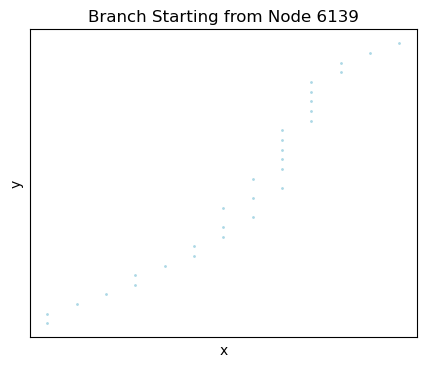

In [898]:
# Extract the subgraph for the branch
branch_subgraph = G.subgraph(valid_nodes_all)

pos = {node: (branch_subgraph.nodes[node]['x'], -1*branch_subgraph.nodes[node]['y']) for node in valid_nodes_all} #G.nodes}

# Draw the branch subgraph
plt.figure(figsize=(5, 4))
nx.draw_networkx_nodes(branch_subgraph, pos, node_color='lightblue', node_size=1) #, edge_color='gray', with_labels=False
plt.title(f"Branch Starting from Node {start_node}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [899]:
'''

0/soma: soma
1/root: root node
2/axon: axon
3/bd: basal dendrite
4/ad: apical dendrite
'''

df_chopped.loc[df_chopped['rowId'].isin(valid_nodes_all),'node_type'] = 'ad'

In [900]:
df_chopped.loc[df_chopped['node_type'].isin([0]),'node_type'] = 'soma'

In [901]:
df_chopped = df_chopped.sort_values('link')

In [902]:
# df_chopped

In [903]:
df_chopped.to_csv(Path(skelpath) / f'{cell_folder}_df_chopped_labeled.csv')

### save to swc format via cloudvolume from df

In [904]:
filename = f'{cell_folder}_for_syn_labeled.swc'
filename

'mg2_386426114_mip3_for_syn_labeled.swc'

In [905]:
df_to_swc_cloudvolume(df_chopped.replace(to_replace={'soma':0,'axon':2,'bd':3,'ad':4}), swc_outpath, filename)

### distances from all nodes to root of soma

In [703]:
def add_electrotonic_weights(G):
    for u, v, data in G.edges(data=True):
        # Get node radii
        r1 = G.nodes[u]['radius']
        r2 = G.nodes[v]['radius']
        
        # Get physical edge length
        dx = data['distance']
        
        # Electrotonic distance weight
        if r1 > 0 and r2 > 0:
            elec_dist = dx / np.sqrt(r1 * r2)
        else:
            elec_dist = np.inf  # prevent divide by zero
        
        # Add it to the edge attributes
        data['electrotonic_distance'] = elec_dist
        
def compute_axial_resistance(dx_nm, r1_nm, r2_nm, Ra_ohm_cm=100):
    dx_cm = dx_nm * 1e-7  # convert nm to cm
    r_cm = (r1_nm + r2_nm) / 2 * 1e-7
    if r_cm == 0:
        return np.inf  # avoid division by zero
    return Ra_ohm_cm * dx_cm / (np.pi * r_cm**2)

def add_axial_resistance_weights(G, Ra=100):
    for u, v, data in G.edges(data=True):
        dx = data['distance']  # in nm
        r1 = G.nodes[u]['radius']  # in nm
        r2 = G.nodes[v]['radius']  # in nm
        R_axial = compute_axial_resistance(dx, r1, r2, Ra_ohm_cm=Ra)
        data['axial_resistance'] = R_axial

def compute_lambda_cm(radius_cm, Rm_ohm_cm2, Ra_ohm_cm):
    if radius_cm <= 0:
        return np.inf  # no conduction possible
    return np.sqrt((radius_cm * Rm_ohm_cm2) / (2 * Ra_ohm_cm))

def compute_electrotonic_distance(dx_nm, r1_nm, r2_nm, Rm=20000, Ra=100):
    dx_cm = dx_nm * 1e-7
    r_cm = (r1_nm + r2_nm) / 2 * 1e-7
    lam = compute_lambda_cm(r_cm, Rm, Ra)
    if lam == 0 or np.isinf(lam):
        return np.inf
    return dx_cm / lam

def add_lambda_based_electrotonic_weights(G, Rm=20000, Ra=100):
    for u, v, data in G.edges(data=True):
        dx = data['distance']
        r1 = G.nodes[u]['radius']
        r2 = G.nodes[v]['radius']
        elec_dist = compute_electrotonic_distance(dx, r1, r2, Rm, Ra)
        data['electrotonic_lambda'] = elec_dist


In [906]:
cell_folder_list = ['mg2_386426114_mip3']#['mg1_299496636_mip3','mg2_299404889_mip3','mg2_126649726_mip3','mg2_213605530_mip3','mg2_214581797_mip3','mg2_386426114_mip3']

skelpath = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc/'


In [907]:
for cell_folder in cell_folder_list:
    df_chopped = pd.read_csv(Path(skelpath) / f'{cell_folder}_df_chopped_labeled.csv')
    df_chopped = df_chopped[['rowId', 'node_type', 'x', 'y', 'z',
           'radius', 'link']]
    
    G = npskel.skeleton_df_to_nx(df_chopped, with_attributes=True, directed=True, with_distances=True, virtual_roots=False)
    G = G.reverse()
    
    # Example usage:
    add_electrotonic_weights(G)
    add_lambda_based_electrotonic_weights(G)
    
    
    
    root_node = df_chopped[df_chopped['link']==-1]['rowId'].values[0]
    for i,r in df_chopped.iterrows():
        
        pathL = nx.shortest_path_length(G,root_node,r['rowId'],weight='distance')
        
        electrotonic_path_length = nx.shortest_path_length(
            G, 
            source=root_node, 
            target=r['rowId'], 
            weight='electrotonic_distance'
            )
        
        lambda_distance = nx.shortest_path_length(
            G, 
            source=root_node, 
            target=r['rowId'], 
            weight='electrotonic_lambda'
        )
    
        df_chopped.loc[df_chopped['rowId']==r['rowId'],'distance_path'] = pathL
        df_chopped.loc[df_chopped['rowId']==r['rowId'],'distance_electro'] = electrotonic_path_length
        df_chopped.loc[df_chopped['rowId']==r['rowId'],'distance_lambda'] = lambda_distance
    
    # for the rest of the plots, make apical dendrite distance in the opposite direction as basal dendrite, soma and axon distance
    condition = df_chopped['node_type'].isin(['ad'])
    df_chopped.loc[condition,'distance_path'] = df_chopped[condition]['distance_path']*-1
    df_chopped.loc[condition,'distance_electro'] = df_chopped[condition]['distance_electro']*-1
    df_chopped.loc[condition,'distance_lambda'] = df_chopped[condition]['distance_lambda']*-1
    
    df_chopped.to_csv(Path(skelpath) / f'{cell_folder}_df_chopped_labeled_distances.csv')
    
    cid = cell_folder.split('_')[1]
    mask = df_syn['post'].isin([int(cid)]) & df_syn['pre_type'].isin(['mg1','mg2','sg1','sg2','grc','smpl','aff'])
    df_focal_syn = df_syn[mask][['post','pre','x','y','z','pre_type','post_type']]
    
    for i,r in df_focal_syn.iterrows(): #for each row, get node ID (and distance_path) of skel node closes to synapse
        # for now, us euclidean distance... can't think of what else would do better yet around soma area where axon gets close to other structures... 
        target_coords = tuple(r[['x','y','z']])
        closest_row = find_closest_row(df_chopped, tuple(target_coords), multipliers = (1000,1000,1000))
        df_focal_syn.loc[i,'nodeId'] = closest_row['rowId']
        df_focal_syn.loc[i,'distance_path'] = closest_row['distance_path']
        df_focal_syn.loc[i,'distance_electro'] = closest_row['distance_electro']
        df_focal_syn.loc[i,'distance_lambda'] = closest_row['distance_lambda']
        df_focal_syn.loc[i,'node_type'] = closest_row['node_type']
        df_focal_syn.loc[i,'link'] = closest_row['link']
    
    df_focal_syn.to_csv(Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/biophysical_model/dfs_presyn_labeled') / f'{cell_folder}.csv')

In [911]:
condition = df_chopped['node_type'].isin(['ad'])
df_chopped.loc[condition,'distance_path'] = df_chopped[condition]['distance_path']*-1
df_chopped.loc[condition,'distance_electro'] = df_chopped[condition]['distance_electro']*-1
df_chopped.loc[condition,'distance_lambda'] = df_chopped[condition]['distance_lambda']*-1

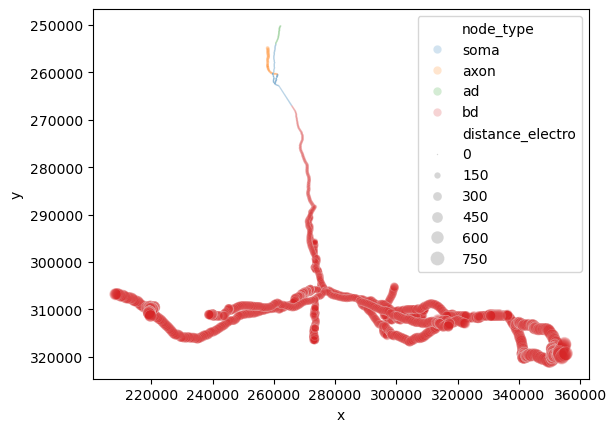

In [909]:
ax = sns.scatterplot(data = df_chopped,hue='node_type',x='x',y='y',size='distance_electro',sizes=(1,100),alpha=0.2)
ax.invert_yaxis()

<AxesSubplot:xlabel='Density', ylabel='distance_electro'>

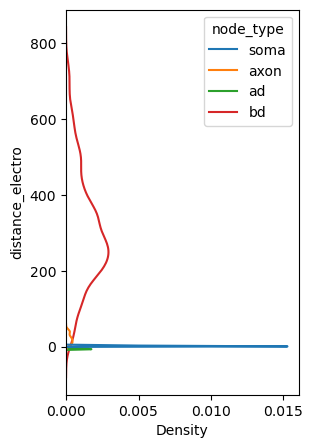

In [912]:
hfig,ax = plt.subplots(figsize=(3,5))
sns.kdeplot(ax=ax,data = df_chopped,y = 'distance_electro',hue='node_type')

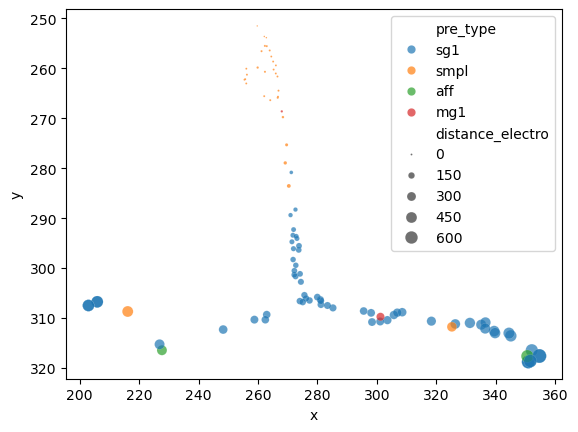

In [913]:
ax = sns.scatterplot(data = df_focal_syn,hue='pre_type',x='x',y='y',alpha=0.7,size='distance_electro',sizes=(1,100))
ax.invert_yaxis()

<AxesSubplot:xlabel='Count', ylabel='distance_electro'>

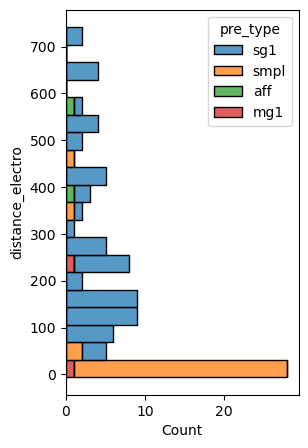

In [914]:
hfig,ax = plt.subplots(figsize=(3,5))
sns.histplot(ax=ax,data = df_focal_syn,y = 'distance_electro',hue='pre_type',multiple='stack',bins=20)#,cut=0)

<AxesSubplot:xlabel='Density', ylabel='distance_electro'>

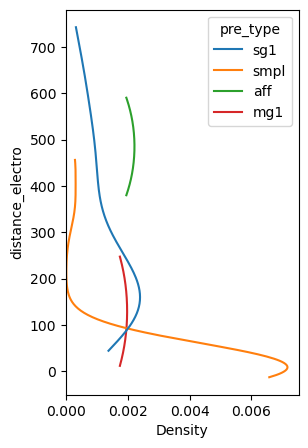

In [857]:
hfig,ax = plt.subplots(figsize=(3,5))
sns.kdeplot(ax=ax,data = df_focal_syn,y = 'distance_electro',hue='pre_type',cut=0,common_norm=False)

<AxesSubplot:xlabel='node_type', ylabel='distance_electro'>

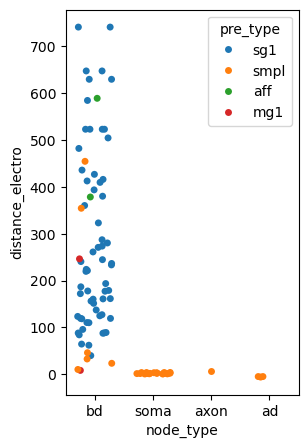

In [915]:
hfig,ax = plt.subplots(figsize=(3,5))
sns.stripplot(ax=ax,data = df_focal_syn,x = 'node_type',y = 'distance_electro',hue='pre_type',jitter=0.3)

In [531]:
[p*r/v for p,r,v in zip((2552, 968, 517),(128,128,120),(16,16,30))]

[20416.0, 7744.0, 2068.0]

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_10352/3520875891.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(ax=ax,data = df_tmp[mask],hue='pre',x='x',y='y',alpha=1)


<AxesSubplot:xlabel='Count', ylabel='distance_path'>

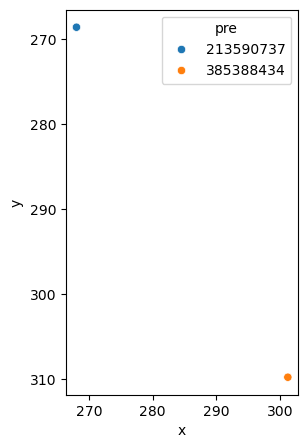

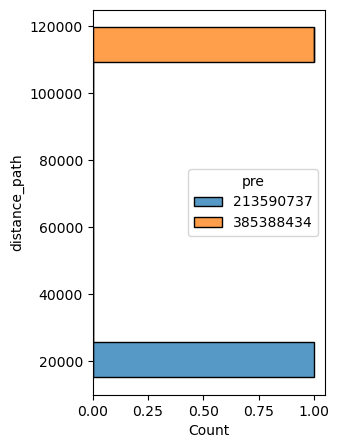

In [859]:
# df_focal_syn.head()
df_tmp = deepcopy(df_focal_syn)
df_tmp['pre'] = [str(p) for p in df_tmp['pre']]
mask = df_tmp['pre_type'].isin(['mg1'])
df_tmp = df_tmp[mask]
hfig,ax = plt.subplots(figsize=(3,5))
sns.scatterplot(ax=ax,data = df_tmp[mask],hue='pre',x='x',y='y',alpha=1)
ax.invert_yaxis()

hfig,ax = plt.subplots(figsize=(3,5))
sns.histplot(ax=ax,data = df_tmp,y = 'distance_path',hue='pre',multiple='stack',bins=10)

### Consolidate across cells that have been processed

In [916]:
presyn_distances_path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/biophysical_model/dfs_presyn_labeled') 

df_syn_list = [file_path for file_path in presyn_distances_path.iterdir() if file_path.is_file() and '.csv' in file_path.name]

all_df = []
for dpath in df_syn_list:

    df = pd.read_csv(dpath)
    all_df.append(df)

combined_df = pd.concat(all_df, ignore_index=True)

In [917]:
combined_df['post'] = combined_df['post'].astype(str)

In [918]:
combined_df['distance_electro'].max()

952.3897943122176

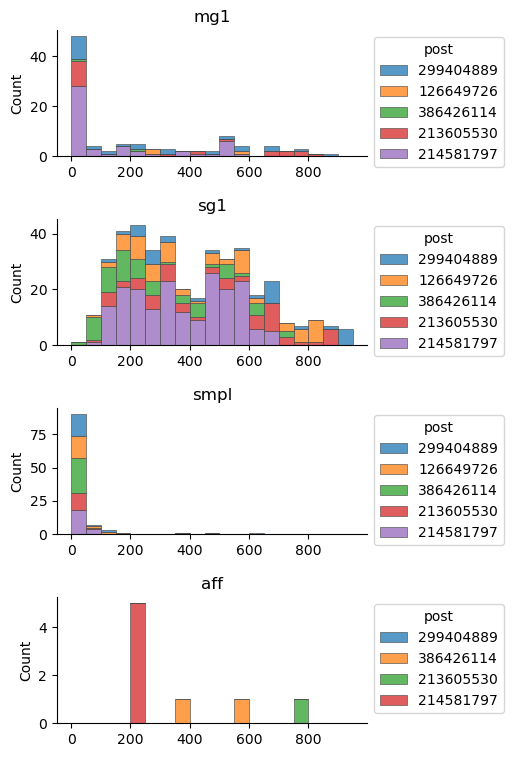

In [919]:
hfig,ax = plt.subplots(4,figsize=(4,9))
plt.subplots_adjust(hspace=0.5)
sns.despine(hfig)
for pre_type,ax_ in zip(['mg1','sg1','smpl','aff'],ax): #['mg2','sg2','grc']
    mask = combined_df['post_type'].isin(['mg2']) & combined_df['pre_type'].isin([pre_type])
   
    sns.histplot(combined_df[mask],x="distance_electro", hue="post",
        multiple="stack",edgecolor=".3",linewidth=.45,bins=range(0,1000,50),ax = ax_
    )
    sns.move_legend(ax_, "upper left", bbox_to_anchor=(1, 1))
    ax_.set_title(pre_type)
    ax_.set_xlabel('')
# ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([500, 1000, 2000, 5000, 10000])


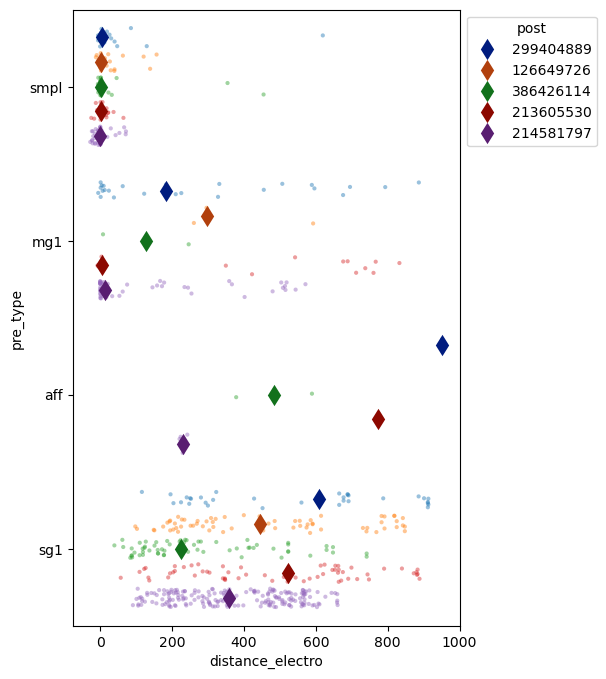

In [920]:
mask = combined_df['post_type'].isin(['mg2']) & combined_df['pre_type'].isin(['mg1','sg1','smpl','aff'])

hfig,ax = plt.subplots(1,figsize=(5,8))
# Show each observation with a scatterplot
sns.stripplot(ax=ax,
    data=combined_df[mask], x="distance_electro", y="pre_type", hue="post",
    dodge=True, alpha=.45, zorder=1, legend=False,jitter=0.3, size=3#palette='dark'
)
# sns.swarmplot(ax=ax,
#     data=combined_df[mask], x="distance_electro", y="pre_type", hue="post",
#     dodge=True, alpha=.45, zorder=1, legend=False,size=3 #palette='dark'
# )

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
# sns.boxplot(ax=ax,
#     data=combined_df[mask], x="distance_electro", y="pre_type", hue="post",
#     dodge=.8 - .8 / 4)#, palette="light")
#     # markers="d", markersize=4, linestyle="none"
# # ) #, errorbar=None,

sns.pointplot(ax=ax,
    data=combined_df[mask], x="distance_electro", y="pre_type", hue="post",
    dodge=.8 - .8 / combined_df[mask]['post'].nunique(), palette="dark", errorbar=None,
    markers="d", markersize=8, linestyle="none", estimator='median'
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

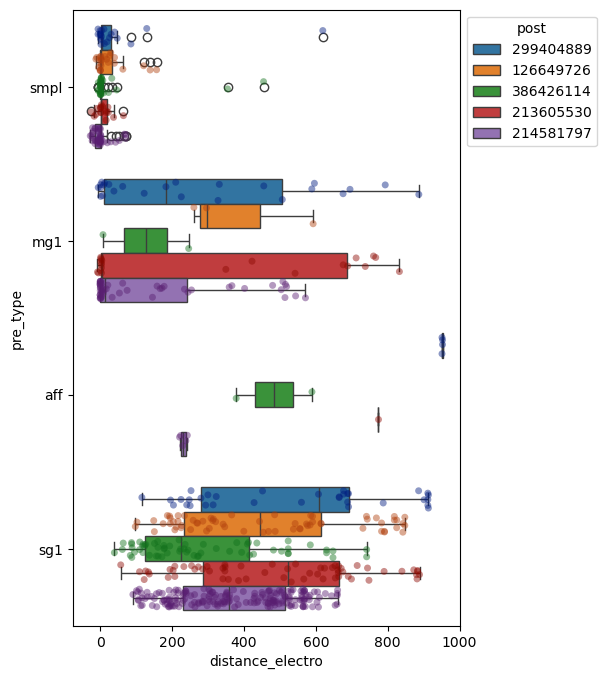

In [921]:
mask = combined_df['post_type'].isin(['mg2']) & combined_df['pre_type'].isin(['mg1','sg1','smpl','aff'])

hfig,ax = plt.subplots(1,figsize=(5,8))
# Show each observation with a scatterplot
sns.stripplot(ax=ax,
    data=combined_df[mask], x="distance_electro", y="pre_type", hue="post",
    dodge=True, alpha=.45, zorder=3, legend=False,jitter=0.3, palette='dark'
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.boxplot(ax=ax,
    data=combined_df[mask], x="distance_electro", y="pre_type", hue="post",
    dodge=.8 - .8 / 4)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_10352/2672898703.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=ax,data = combined_df[mask],y = 'distance_electro',hue='pre_type',cut=0)#,common_norm=False)


<AxesSubplot:xlabel='Density', ylabel='distance_electro'>

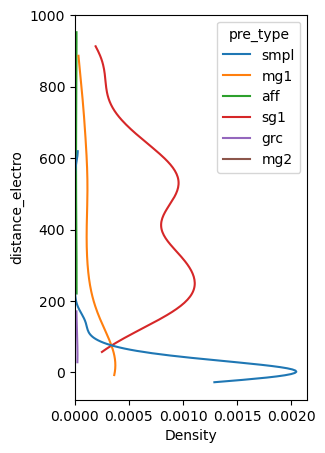

In [746]:
hfig,ax = plt.subplots(figsize=(3,5))
mask = combined_df['post_type'].isin(['mg2'])
sns.kdeplot(ax=ax,data = combined_df[mask],y = 'distance_electro',hue='pre_type',cut=0)#,common_norm=False)

## soma synapses

In [38]:
df_syn.head()
mask = df_syn['post_type'].isin(['mg1','mg2','lg']) & df_syn['pre_type'].isin(['aff','grc','smpl','sg1','sg2'])
df_syn[mask].head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2
6,6,126649726,47692492,axon,323.216,259.600,19.02,-7.687260,smpl,mg2


<AxesSubplot:xlabel='x', ylabel='y_adj'>

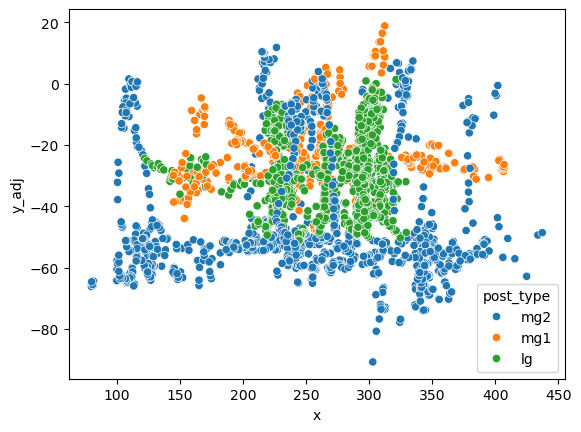

In [39]:
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue = 'post_type')

In [37]:
df_syn[mask].groupby(['post_type','post','pre_type']).count()

Unnamed: 0  pre  structure   x   y   z  y_adj
post_type post      pre_type                                               
lg        300474334 grc                6    6          6   6   6   6      6
          301787806 grc                1    1          1   1   1   1      1
          472392041 grc                4    4          4   4   4   4      4
                    sg1                1    1          1   1   1   1      1
mg1       299392199 grc                7    7          7   7   7   7      7
          299405462 grc                4    4          4   4   4   4      4
mg2       213605530 aff                1    1          1   1   1   1      1
          214581797 aff                3    3          3   3   3   3      3
          215492896 aff               24   24         24  24  24  24     24
          221746236 aff               38   38         38  38  38  38     38
          299404889 aff                4    4          4   4   4   4      4
          300226567 aff               33   33         33  33  33  33     33
          385434515 aff                5    5          5   5   5   5      5
          386392158 aff                7    7          7   7   7   7      7
          386426114 aff                2    2          2   2   2   2      2

# Connectivity Similarity

## correlation

In [68]:
# Desired source and order
source_types_order = ['grc']#['lg','mg1','lf','mg2']#['lg','mg1','sg1','smpl','lf','mg2','sg2','grc']

# Desired targets order
target_types_order = ['aff','grc', 'smpl','sg2', 'sg1', 'mg2', 'mg1','uk','fov']  #['aff', 'smpl','sgx1','sg1', 'grc', 'sgx2', 'sg2']#

In [82]:
# dsource = 'post_type'
# idsource = 'post'
# dtarget = 'pre_type'

# post-synaptic labeling
dsource = 'post_type'
idsource = 'post'
dtarget = 'pre_type'

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order) & df_edges['post'].isin([397967979, 482680782, 483689146, 142617839, 395461156, 228366816])]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

In [81]:
df_edges['post'].values

array([397967979, 481412554, 389891998, ..., 482680782, 393325331,
       395461156])

In [83]:
pivot_df.head()

pre_type,post_type,aff,grc,smpl,sg2,sg1,mg2,mg1,uk,fov
post,,,,,,,,,,
142617839,grc,18,0,1,0,0,0,0,14,58
228366816,grc,10,0,0,0,0,0,0,35,3
395461156,grc,19,0,7,0,0,0,0,9,36
397967979,grc,57,0,0,0,0,0,0,4,37
482680782,grc,61,0,6,0,0,0,0,10,125


In [44]:
pivot_df[pivot_df['post_type'].isin(['mg2'])].index

Int64Index([386426114, 299404889, 214581797, 213605530, 126649726], dtype='int64', name='post')

## cosine similarity

In [71]:
def cosine_similarity(A, B):
    # The time-series data sets should be normalized.
    A_norm = (A - np.mean(A)) / np.std(A)
    B_norm = (B - np.mean(B)) / np.std(B)
 
    # Determining the dot product of the normalized time series data sets.
    dot_product = np.dot(A_norm, B_norm)
 
    # Determining the Euclidean norm for each normalized time-series data collection.
    norm_A = np.linalg.norm(A_norm)
    norm_B = np.linalg.norm(B_norm)
 
    # Calculate the cosine similarity of the normalized time series data 
    # using the dot product and Euclidean norms. setse-series data set
    cosine_sim = dot_product / (norm_A * norm_B)
 
    return cosine_sim
    
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from numpy.linalg import norm


In [46]:
pivot_df.head()

pre_type,post_type,aff,grc,smpl,sg2,sg1,mg2,mg1
post,,,,,,,,
301787806,lg,0,199,1,157,0,45,0
300474334,lg,0,176,0,61,0,42,0
301727988,lg,0,78,0,55,0,20,0
472392041,lg,0,195,4,58,1,44,0
302637877,lg,0,7,0,29,0,47,0


In [84]:
# Normalize each row to unit length (L2 norm)
pivot_df_corr = pivot_df.drop(columns=[dsource])
# pivot_df_corr=pivot_df_corr.apply(zscore, axis=1) # DO NOT Z-SCORE: it will then just be correlation coefficient 
# (https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)
normalized_df = pivot_df_corr.div(norm(pivot_df_corr, axis=1), axis=0)
normalized_df.dropna(inplace=True)#.replace(np.NaN,0)

In [85]:
cosine_sim_matrix = pairwise_distances(normalized_df, metric='cosine')
cosine_sim_matrix = 1-cosine_sim_matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=normalized_df.index, columns=normalized_df.index)

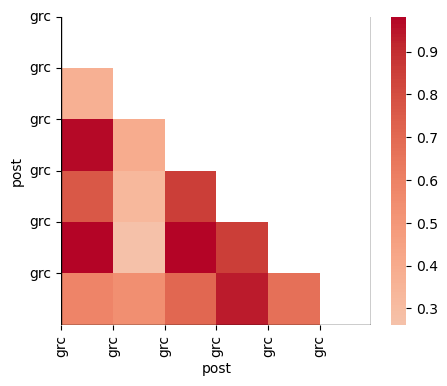

In [86]:
# Create the heatmap
plt.figure(figsize=(5, 4))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cosine_sim_df, dtype=bool))

heatmap = sns.heatmap(cosine_sim_df, mask=mask,cmap='coolwarm', annot=False, fmt='.2f', cbar=True,center=0) #

# Add post_type labels and lines
current_position = 0
total_position=len(pivot_df)
for dtype in source_types_order:
    n = (pivot_df[dsource] == dtype).sum()
    if n > 0:
        # heatmap.axhline(current_position,current_position/len(pivot_df), total_position, color='black', linewidth=1)
        # heatmap.axvline(current_position,1-(current_position/len(pivot_df)), total_position, color='black', linewidth=1)
        heatmap.axhline(current_position,0, current_position/len(pivot_df), color='black', linewidth=1)
        heatmap.axvline(current_position,0, 1-(current_position/len(pivot_df)), color='black', linewidth=1)
        current_position += n
heatmap.axhline(current_position, color='black', linewidth=1)
heatmap.axvline(current_position, color='black', linewidth=1)

# Set labels
heatmap.set_xticks(range(0,len(pivot_df)))
heatmap.set_yticks(range(0,len(pivot_df)))
heatmap.set_xticklabels(pivot_df[dsource].values, rotation=90)
heatmap.set_yticklabels(pivot_df[dsource].values, rotation=0)

# plt.title('Similarity Heatmap')
# plt.show()
plt.savefig('/Users/kperks/Downloads/MG_cosine_similarity_input.svg',transparent=True) 

In [78]:
cosine_sim_df

Int64Index([142617839, 222597526, 223881844, 226019332, 227254070, 228321391,
            228366816, 313068329, 395461156, 397967979, 400210172, 403522169,
            481412554, 482680782, 483610898, 483689146],
           dtype='int64', name='post')

<Figure size 500x400 with 0 Axes>

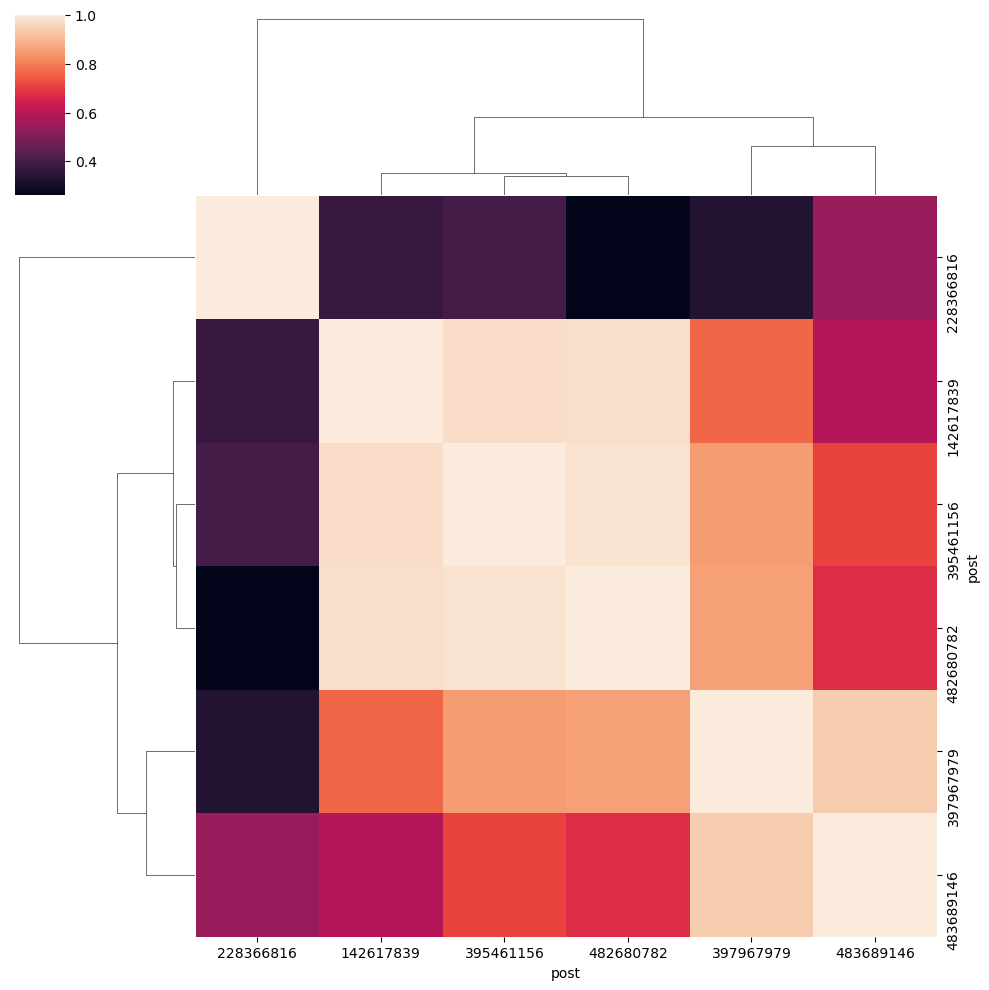

In [88]:
# plt.figure(figsize=(5, 4))
sns.clustermap(cosine_sim_df)

# Connection patterns

In [52]:
count_type = 'nsyn' # 'ncells' #
mask = (df_edges['pre_type'].isin(['aff','grc','smpl','sg1','sg2']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

types_ = ['mg1','mg2']#['lg','lf'] #, 
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['post_type']==t) & mask].groupby(
            ['post','post_type','pre_type']).sum(numeric_only=True).reset_index().pivot(
            index='post', columns='pre_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['post_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('post')
df_map = df_map.drop(['post_type'],axis=1)

In [53]:
df_map.head()

pre_type,grc,sg2,smpl,aff,sg1
post,,,,,
299392199,25.0,39.0,4.0,0.0,0.0
299405462,60.0,14.0,6.0,0.0,0.0
299439953,31.0,48.0,0.0,0.0,0.0
299496636,111.0,106.0,0.0,0.0,0.0
386224676,37.0,30.0,0.0,0.0,0.0


## connectivity heatmap

[]

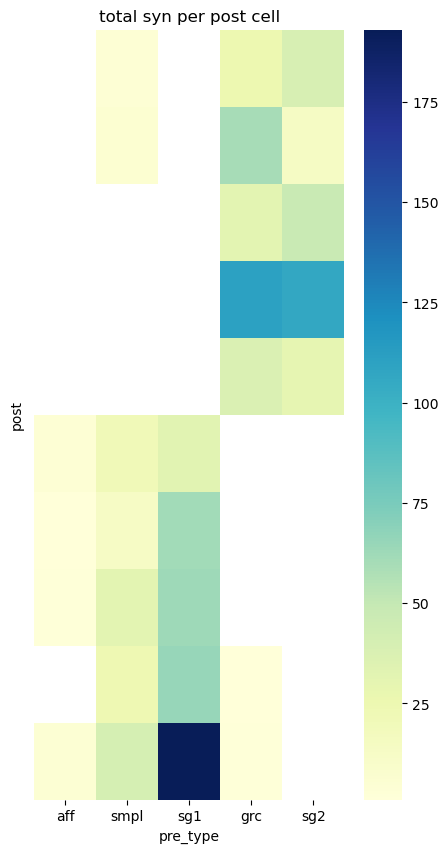

In [54]:
target_order = ['aff','smpl','sg1','grc','sg2']#['lg','mg1','lf','mg2']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

cmap = sns.color_palette("YlGnBu", as_cmap=True)  # Base colormap
cmap.set_under('white')  # Set color for values below the colormap's minimum (i.e., 0)

# Ensure all 0s are treated as "under" the colormap range
# df_map = df_map.replace(0, -1)  # Replace 0s with a value below the colormap range


# fig, axes = plt.subplots(1, figsize=(5,10))
# sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap="YlGnBu", ax=axes)#  .sort_index()
# # sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])
# axes.set_title('total syn per pre cell')




# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=df_map.sort_values(['sg1']), annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per post cell')
axes.set_yticks([])



In [55]:
sg1_map = df_map[df_map['sg1']>1].sort_values(['sg1'])

In [56]:
sg2_map = df_map[~df_map.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

In [57]:
sorted_full = pd.concat([sg2_map,sg1_map])

[]

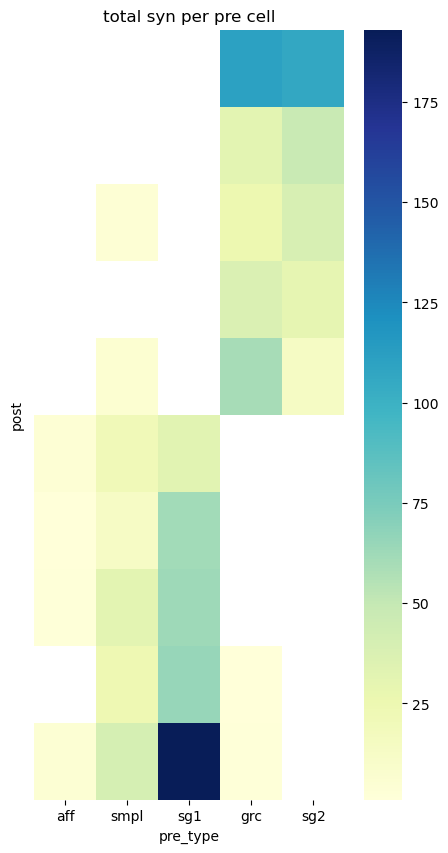

In [58]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

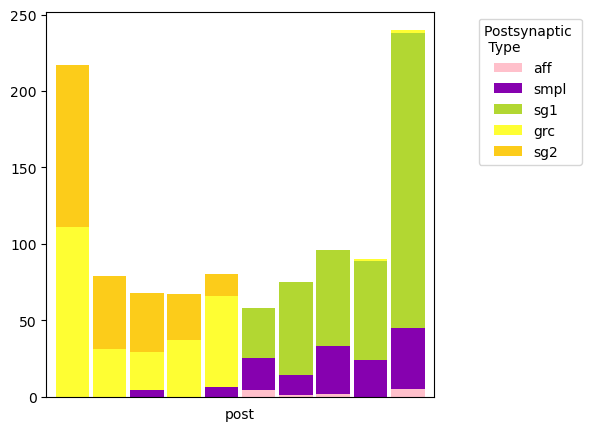

In [59]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
# Create a stacked bar plot
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.4, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/MG_stacked_bar_presyn.svg', format='svg', transparent=True)

In [221]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100)#.round(0)

In [222]:
sg1_map = df_norm[df_norm['sg1']>1].sort_values(['sg1'])

sg2_map = df_norm[~df_norm.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

norm_sorted_full = pd.concat([sg2_map,sg1_map])

[]

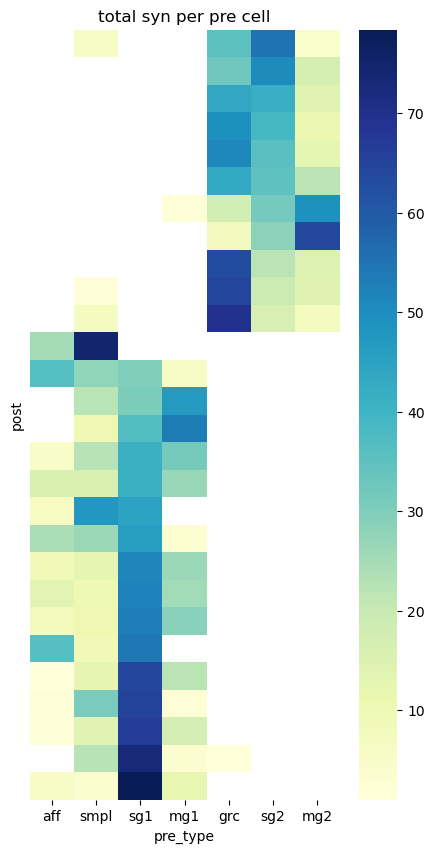

In [223]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=norm_sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

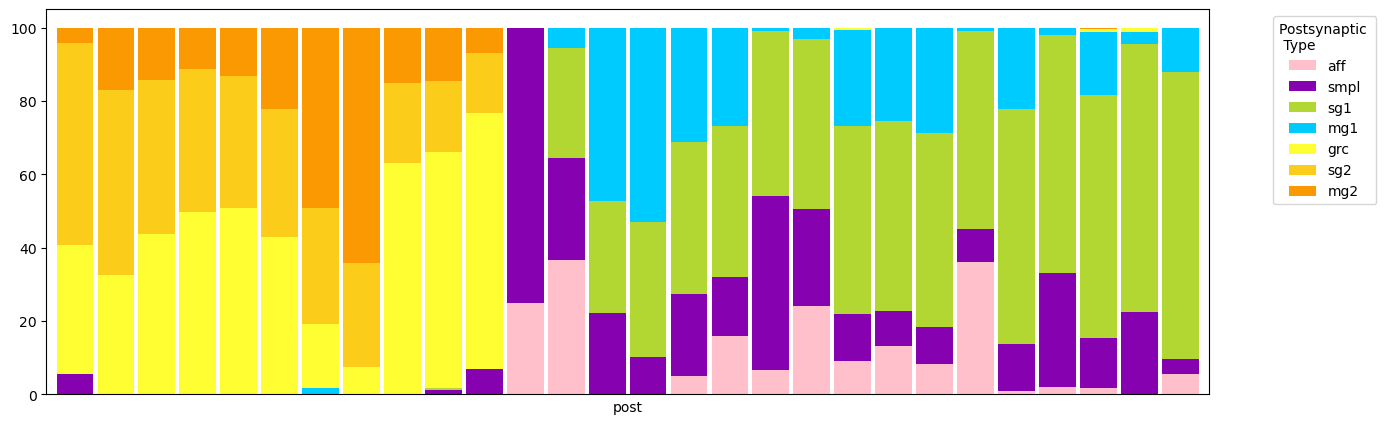

In [224]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
# Create a stacked bar plot
norm_sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/mg_output_stacked_bar_presyn_normalized.svg', format='svg', transparent=True)

# KC fig 4 analysis

In [434]:
def get_p_connect(df_edges,count_type):

# count_type = 'nsyn' # 'ncells' #
# mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

    # types_ = ['mg1','mg2','lg','lf']# 
    # df_map = pd.DataFrame()
    # for t in types_:
    #     if count_type == 'nsyn':
    #         df_grouped = df_edges[(df_edges['post_type']==t)].groupby(
    #             ['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
    #             index='post', columns='pre_type', values='weight').fillna(0).reset_index()
        
    #     # if count_type == 'ncells':
    #     #     df_grouped = df_edges[(df_edges['pre_type']==t)].groupby(
    #     #         ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     #         index='pre', columns='post_type', values='post').fillna(0).reset_index()
        
    #     df_grouped['post_type']=t
    #     df_map = pd.concat([df_map,df_grouped])
        
    # df_map = df_map.fillna(0)
    # df_map = df_map.set_index('post')
    # df_map = df_map.drop(['post_type'],axis=1)

    df_map = df_edges.groupby(['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='post', columns='pre_type', values='weight').fillna(0).reset_index().set_index('post')
    
    df_norm = df_map.div(df_map.sum(axis=1),axis=0)#.mul(100).round(0)

    return df_norm
# sns.heatmap(data=df_norm.sort_values('lcf'), annot=True, fmt="0.0f", cmap="YlGnBu")

## data

In [74]:
df_syn['post_type'].unique()

array(['mg2', 'sg1', 'sgx1', 'sg2', 'smpl', 'grc', 'mli', 'mg1', 'lg',
       'lf', 'sgx2', 'h'], dtype=object)

In [75]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2


## connection probability by cell type

In [465]:
count_type = 'nsyn'
included_groups = ['aff','smpl','sg1','grc','sg2']
by_group='sg2'

### data

In [466]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(included_groups) & df_syn_data['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]
# df_syn_data.to_csv('/Users/kperks/Downloads/df_syn_data.csv')
df_edges_data=df_syn_data.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

df_norm_data = get_p_connect(df_edges_data,count_type)


result_data = df_norm_data[(df_norm_data[by_group] != 0)].mean()

### shuffle result

In [467]:
result_shuff = pd.DataFrame()

# Iterate the specified number of times
for i in range(10):
    df_syn_shuff = deepcopy(df_syn)
    mask = df_syn_shuff['pre_type'].isin(included_groups) & df_syn_shuff['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

    df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

    df_norm_shuff = get_p_connect(df_edges_shuff,count_type)
    
    # Compute the mean for rows where 'mg2' is not zero
    mean_row = df_norm_shuff[(df_norm_shuff[by_group] != 0)].mean(numeric_only=True) #df_shuffled[df_shuffled[by_group] != 0].mean(numeric_only=True)
    
    # Append the result as a row to the result_df
    result_shuff = pd.concat([result_shuff, pd.DataFrame([mean_row])], ignore_index=True)

### plot comparison

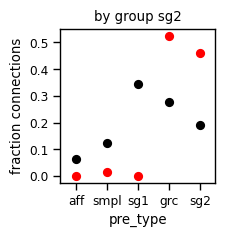

In [468]:
hfig,ax = plt.subplots(1,figsize=(2,2))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')

# plot iteration means
sns.pointplot(data = result_shuff,linestyle='',color = 'black',markersize = 5,order = included_groups,errorbar=('ci'))
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5,order = included_groups)

ax.set_ylabel('fraction connections')
ax.set_title(f'by group {by_group}')

plt.savefig(f'/Users/kperks/Downloads/input_conditionalP_{by_group}.svg', format='svg', transparent=True)

# conditional input analysis

In [444]:
def get_conditional_input(df_edges,normalize=False):
    '''get p(connect)'''
    df_map = df_edges.groupby(['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='post', columns='pre_type', values='weight').fillna(0).reset_index().set_index('post')

    if normalize==True:
        df_map = df_map.div(df_map.sum(axis=1),axis=0)
    
    '''group data'''
    result = []
    for g in df_map.columns:
        result.append(list(df_map[(df_map[g] > 0.05)].mean().values))
    
    return result

In [425]:
included_groups = ['aff','smpl','sg1','grc','sg2']

### shuffle result

In [445]:
result_shuff = []

# Iterate the specified number of times
for i in range(100):
    df_syn_shuff = deepcopy(df_syn)
    mask = df_syn_shuff['pre_type'].isin(included_groups) & df_syn_shuff['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

    df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

    result_ = np.asarray(get_conditional_input(df_edges_shuff,normalize=True))
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)

u_mat = result_shuff.mean(axis=0)

std_mat = result_shuff.std(axis=0)

In [447]:
std_mat

array([[0.004002  , 0.00787315, 0.00819451, 0.0072432 , 0.00554232],
       [0.00307996, 0.00610087, 0.00576006, 0.00536658, 0.00393281],
       [0.00307996, 0.00610087, 0.00576006, 0.00536658, 0.00393281],
       [0.00300618, 0.00601076, 0.00556806, 0.00505862, 0.00377186],
       [0.00288561, 0.00596728, 0.00577942, 0.00492433, 0.00408652]])

### data

In [450]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(included_groups) & df_syn_data['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]

df_edges_data=df_syn_data.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

result_data = get_conditional_input(df_edges_data,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero


cond_input_mat = pd.DataFrame(z_scores,columns = df_map.columns, index = df_map.columns)


In [451]:
cond_input_mat

pre_type,aff,grc,sg1,sg2,smpl
pre_type,,,,,
aff,27.228750,-35.233590,23.773180,-25.212609,28.190410
grc,-20.526669,39.760386,-60.473321,51.471580,-27.270076
sg1,17.795998,-45.900204,51.153806,-34.519880,29.450945
sg2,-20.993949,40.393723,-62.518821,54.456665,-28.381923
smpl,16.224483,-36.966642,33.462364,-29.427935,30.659936


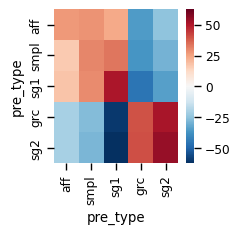

In [452]:

# Define the desired order
order = ['aff', 'smpl', 'sg1', 'grc', 'sg2']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

plt.savefig('/Users/kperks/Downloads/mg_output_conditional_input_analysis.svg', format='svg', transparent=True)

### an example of shuffle result

<AxesSubplot:xlabel='pre_type', ylabel='pre_type'>

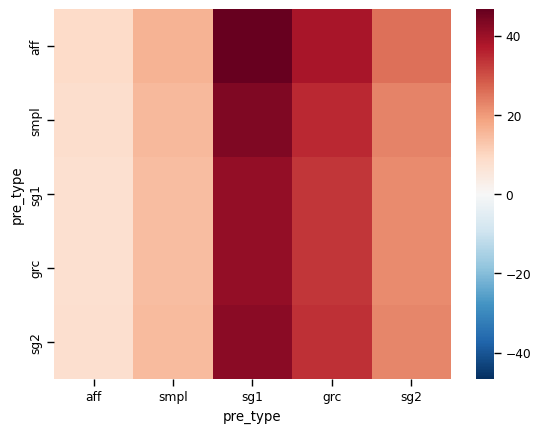

In [408]:

df_syn_shuff = deepcopy(df_syn)
mask = df_syn_shuff['pre_type'].isin(included_groups) & df_syn_shuff['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_shuff = df_syn_shuff[mask]
# Shuffle the dataframe
# df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

result_ = np.asarray(get_conditional_input(df_edges_shuff))

cond_input_mat = pd.DataFrame(result_,columns = df_map.columns, index = df_map.columns)

# Define the desired order
order = ['aff', 'smpl', 'sg1', 'grc', 'sg2']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

# Patterns of connectivity (PCA)

In [62]:
def calculate_percent_total(row):
    total = row.sum()
    if total == 0:
        return row  # If total is 0, return the row as is (unchanged)
    else:
        return row / total  # Normalize by dividing each element by the total
#row / total 

## params of analysis

In [469]:
# post-synaptic labeling
dsource = 'post_type'
idsource = 'post'
dtarget = 'pre_type'

# Desired pre_types and order
source_types_order = ['lg','mg1','lf','mg2']#['pf']#
# Desired post_types order
target_types_order =  ['aff', 'smpl', 'sg1', 'grc', 'sg2']#['mg1','lg', 'mg2','lf'] #

## data

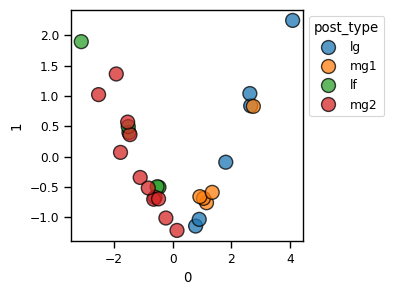

In [482]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data[dsource].isin(source_types_order) & df_syn_data[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]
# df_syn_data.to_csv('/Users/kperks/Downloads/df_syn_data.csv')
df_edges_data=df_syn_data.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

# Pivot table to get sum of weights per post cell and pre_type
pivot_df = df_edges_data.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the function to each row
# norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
norm_df = pivot_df.select_dtypes(include='number')# Standard scaling (next step) should take care of normalizing row-wise, so should not need to do percent total each row, correct? .apply(calculate_percent_total, axis=1) #axis=1 applies function to each row.

# Standardize the data
scaler = StandardScaler(with_mean=True, with_std=True) # should this be scaled based on null model mean and std instead of within df mean and std?
scaled_data = scaler.fit_transform(norm_df)

# Perform PCA
npc = len(target_types_order)
pca = PCA(n_components=npc)  # You can change the number of components as needed

pca_result = pca.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca.components_.T

# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

result_data = pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1),columns=range(len(pca.explained_variance_ratio_)))

hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('/Users/kperks/Downloads/mg_output_PCA.svg', format='svg', transparent=True)



### shuffle result

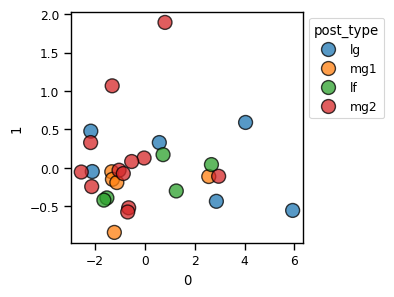

In [483]:
result_df = pd.DataFrame()

# Iterate the specified number of times
for i in range(10):

    df_syn_shuff = deepcopy(df_syn)

    mask = df_syn_shuff[dsource].isin(source_types_order) & df_syn_shuff[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]

    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values
        
    df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')
    
    # Pivot table to get sum of weights per post and pre_type
    pivot_df = df_edges_shuff.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)
    
    # Reindex columns to include only the specified pre_types in the desired order
    pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)
    
    # Reset index to turn 'post' and 'post_type' from index to columns
    pivot_df.reset_index(inplace=True)
    
    # Sort the dataframe based on post_type
    pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
    pivot_df.sort_values(dsource, inplace=True)
    pivot_df.set_index(idsource, inplace=True)
    
    # Apply the function to each row
    # norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
    norm_df = pivot_df.select_dtypes(include='number')#.apply(calculate_percent_total, axis=1)
    
    # Standardize the data
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaled_data = scaler.fit_transform(norm_df)
    
    # Perform PCA
    npc = len(target_types_order)
    pca = PCA(n_components=npc)  # You can change the number of components as needed
    pca_result = pca.fit_transform(scaled_data)

        # get loadings of dimensions onto each principal component
    loadings = pca.components_.T
    
    # Add PCA results to the DataFrame
    for i in range(npc):
        pivot_df[str(i)] = pca_result[:, i]
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1))], ignore_index=True)

hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig('/Users/kperks/Downloads/mg_output_PCA_shuffled.svg', format='svg', transparent=True)

### plot comparison

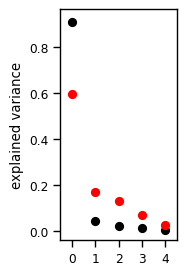

In [478]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 5,errorbar='ci')
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5)

ax.set_ylabel('explained variance')
plt.savefig('/Users/kperks/Downloads/input_pca.svg', format='svg', transparent=True)

In [166]:

# an example iteration of shuffling:
shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_syn_shuff.to_csv('/Users/kperks/Downloads/df_syn_shuff.csv')

# SG input population split for model

In [58]:
metadata_path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/metadata/sg_pre_crude_split.csv')

In [64]:
# open csv into pandas

metadata_df = pd.read_csv(metadata_path)

In [43]:
mask = df_edges['post'].isin([299496636,214581797,393325331,301787806])
df_edges[mask].groupby(['post_type','pre_type'])['pre'].count() #['weight'].sum()

post_type  pre_type
lf         aff           9
           fov         113
           grc           1
           h             8
           mg1          19
           sg1          53
           sgx1         18
           smpl         20
           uk            9
lg         fov          36
           grc         123
           lg            1
           mg2          12
           mli           3
           pe            2
           pf            2
           sg2          30
           sgx2          8
           smpl          1
           uk           10
mg1        fov          66
           grc          87
           mg2          17
           mli          22
           pe           36
           pf           27
           sg2          57
           sgx2         10
           uk            5
mg2        aff           3
           fov          87
           grc           1
           mg1          10
           mg2           1
           mli          18
           pe           33
        

In [89]:
mask = df_edges['post'].isin([299496636,214581797,393325331,301787806]) & df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])
result_df = df_edges[mask]

In [94]:
result_df

,post,pre,pre_type,post_type,weight
6,301787806,214827705,sg2,lg,18
7,301787806,128879866,sg2,lg,16
11,214581797,300459385,mg1,mg2,15
15,393325331,644143297,mg1,lf,14
20,393325331,642905044,mg1,lf,12
...,...,...,...,...,...
5261,299496636,474839189,mg2,mg1,1
5274,299496636,472437904,sg2,mg1,1
5290,301787806,220352133,sg2,lg,1
5334,301787806,137991336,sg2,lg,1


In [100]:
df_type[df_type['id'].isin([214827705])]

,Unnamed: 0,id,cell_type
792,792,214827705,sg2


In [116]:
for i,r in result_df.iterrows():
    # print(i,metadata_df[metadata_df['ID']==r['pre']]['ad_top_half'].values[0])
    # print(r['pre'])
    # print(df_type[df_type['id'].isin([214827705])]['cell_type'].values[0] in ['sg2','sg1'])
    # print(metadata_df[metadata_df['ID']==r['pre']]['ad_top_half'].values[0])
    if df_type[df_type['id'].isin([r['pre']])]['cell_type'].values[0] in ['sg1','sg2']:
        result_df.loc[i,'ad_top_half'] = metadata_df[metadata_df['ID']==r['pre']]['ad_top_half'].values[0]
    if df_type[df_type['id'].isin([r['pre']])]['cell_type'].values[0] in ['mg1','mg2']:
        result_df.loc[i,'ad_top_half'] = 'mg' #df_type[df_type['id']==r['pre']]['cell_type'].values[0]


In [132]:
summary_df = pd.DataFrame(result_df.groupby(['post','ad_top_half'])['pre_type'].count()).reset_index()

In [147]:
summary_df.head()

,post,ad_top_half,pre_type
0,214581797,False,51
1,214581797,True,33
2,214581797,mg,11
3,299496636,False,35
4,299496636,True,20


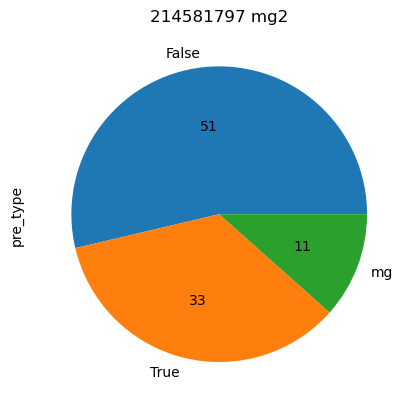

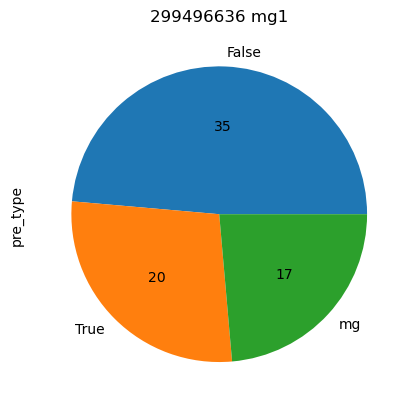

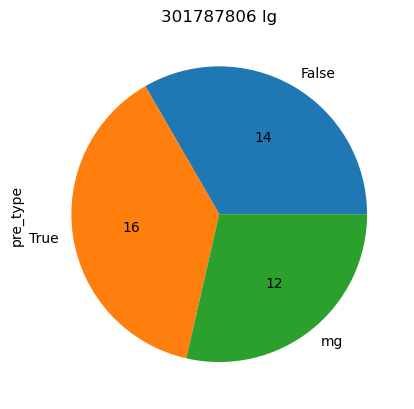

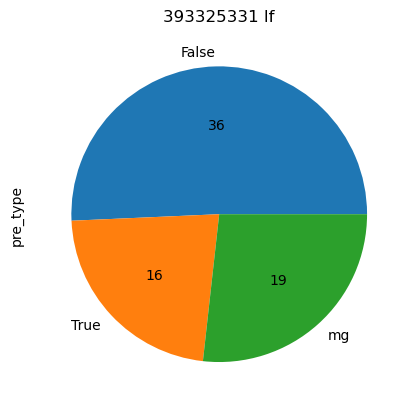

In [146]:
for c_id in summary_df['post'].unique():
    #c_id = 214581797
    ctype = df_type[df_type['id']==c_id]['cell_type'].values[0]
    mask = summary_df['post'].isin([c_id])
    summary_df[mask].plot.pie(y='pre_type', labels=summary_df['ad_top_half'], autopct=lambda p: '{:.0f}'.format(p * sum(summary_df[mask]['pre_type']) / 100),legend=False)# '%1.0f%%')
    plt.title(f'{c_id} {ctype}');

In [148]:
summary_df = pd.DataFrame(result_df.groupby(['post','ad_top_half'])['weight'].sum()).reset_index()

In [149]:
summary_df.head()

,post,ad_top_half,weight
0,214581797,False,102
1,214581797,True,89
2,214581797,mg,51
3,299496636,False,60
4,299496636,True,42


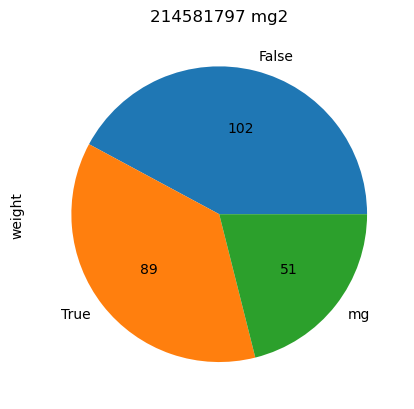

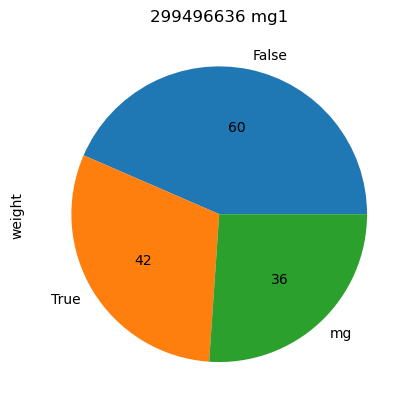

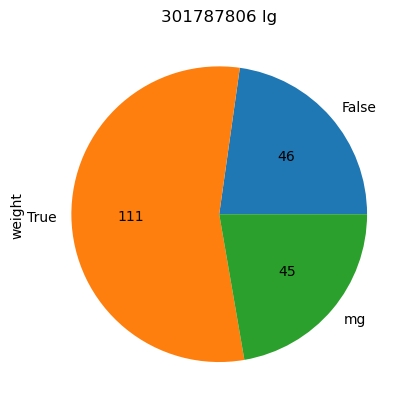

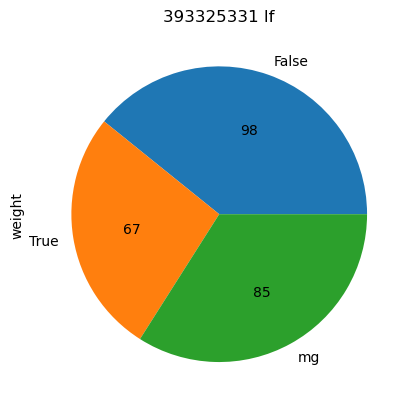

In [151]:
for c_id in summary_df['post'].unique():
    #c_id = 214581797
    ctype = df_type[df_type['id']==c_id]['cell_type'].values[0]
    mask = summary_df['post'].isin([c_id])
    summary_df[mask].plot.pie(y='weight', labels=summary_df['ad_top_half'], autopct=lambda p: '{:.0f}'.format(p * sum(summary_df[mask]['weight']) / 100),legend=False)# '%1.0f%%')
    plt.title(f'{c_id} {ctype}');

# OTHER

## output patterns for grc

## mg_network file names

In [142]:
dirpath = Path(settings_dict['save_dir'])


In [143]:
nodefiles = get_cell_filepaths(dirpath)

In [144]:
len(nodefiles)

5812

## df_syn pre or post

In [145]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn_grc.csv')
syn = 'post-synaptic'

In [146]:
len(df_syn)

1338

In [147]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

# cell types for all files in directory

## from file

In [148]:
df_type = pd.read_csv(dirpath / 'metadata/df_type.csv')

# add cell type to df_syn

In [149]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

# --> df_edges

In [150]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

In [221]:
len(df_edges['pre'].unique())

25

In [151]:
print('grc input to smpl with post syn labeled')
print(df_edges[df_edges['pre'].isin(grc_pre_smpl)]['pre'].unique())
print('')
print('grc input to sg1 with post syn labeled')
print(df_edges[df_edges['pre'].isin(grc_pre_sg1)]['pre'].unique())
print('')
print('grc input to mg1 with post syn labeled')
print(df_edges[df_edges['pre'].isin(grc_pre_mg1)]['pre'].unique())
print('')
print('grc input to lg with post syn labeled')
print(df_edges[df_edges['pre'].isin(grc_pre_lg)]['pre'].unique())

grc input to smpl with post syn labeled
[397842806 568432342 569547308 226095148 484864533 313068329 228383295]

grc input to sg1 with post syn labeled
[311102279 310887446 397842806 222597526 223881844 226095148 400210172
 142617839 228366816 487245609]

grc input to mg1 with post syn labeled
[483689146 310887446 222597526 397967979 142617839 395461156 482680782
 228366816]

grc input to lg with post syn labeled
[310887446 397842806 222597526 397967979 226095148 142617839 395461156
 312018359 482680782 226019332 228383295]


# conditional OUTPUT analysis

In [213]:
def get_conditional_output(df_edges,normalize=False):
    '''get p(connect)'''
    df_map = df_edges.groupby(['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre', columns='post_type', values='weight').fillna(0).reset_index().set_index('pre')

    
    '''group data'''
    result = []
    for g in df_map.columns:
        df_map_mod = deepcopy(df_map[df_map[g]>0])
        df_map_mod.loc[:, g] = df_map_mod[g].apply(lambda x: x - 1)
        # df_map_mod.loc[:,g] = df_map_mod[g]-1
        if normalize==True:
            df_map_mod = df_map_mod.div(df_map_mod.sum(axis=1),axis=0)
        result.append(list(df_map_mod.mean().values))

    # if normalize==False:
    #     '''group data'''
    #     result = []
    #     for g in df_map.columns:
    #         df_map_mod = deepcopy(df_map[df_map[g]>0])
    #         df_map_mod.loc[:, g] = df_map_mod[g].apply(lambda x: x - 1)
    #         result.append(list(df_map_mod.mean().values))

    order = df_map.columns
        
    return result,order

In [208]:
df_map = df_edges_data.groupby(['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre', columns='post_type', values='weight').fillna(0).reset_index().set_index('pre')

In [212]:
g = df_map.columns[0]
df_map.loc[:,g] = df_map[g]-1

In [199]:
pre_groups = ['grc']
post_groups = ['sg1','smpl','mg1','lg']

### shuffle result

In [215]:
result_shuff = []

# Iterate the specified number of times
for i in range(100):
    df_syn_shuff = deepcopy(df_syn)
    mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['post','x','y','z','y_adj','post_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['post']] = shuff_rows['post'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['post_type']] = shuff_rows['post_type'].values

    df_edges_shuff=df_syn_shuff[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

    result_,order = get_conditional_output(df_edges_shuff,normalize=True)
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)

u_mat = result_shuff.mean(axis=0)

std_mat = result_shuff.std(axis=0)

In [216]:
df_edges_shuff.head()

,pre,post,pre_type,post_type,weight
0,397967979,472392041,grc,lg,5
1,226019332,302777004,grc,sg1,4
2,311102279,300474334,grc,lg,4
3,142617839,472392041,grc,lg,4
4,222597526,645162652,grc,lg,4


In [217]:
u_mat

array([[0.15654393, 0.09216462, 0.65036349, 0.10092796],
       [0.19325112, 0.06361111, 0.64223767, 0.1009001 ],
       [0.19577488, 0.09288625, 0.60949939, 0.10183948],
       [0.1929816 , 0.09218638, 0.64408049, 0.07075153]])

### data

In [218]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(pre_groups) & df_syn_data['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]

df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')


result_data,order = get_conditional_output(df_edges_data,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero


cond_input_mat = pd.DataFrame(z_scores,columns = order, index = order)

Text(0.5, 1.0, 'conditional connection probability (0 to 1)')

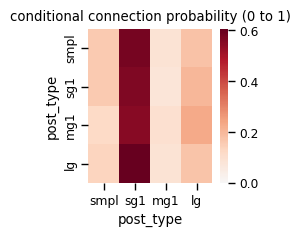

In [226]:
p_connect = pd.DataFrame(result_data,columns = order, index = order)
# Define the desired order
order_disp = ['smpl','sg1','mg1','lg']

# Reorder rows and columns
df_reordered=p_connect.reindex(index=order_disp, columns=order_disp)

# Ensure the color range is centered around 0
vmin = 0#-max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))#-vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)
plt.title('conditional connection probability (0 to 1)')

Text(0.5, 1.0, 'z-score to shuffled data')

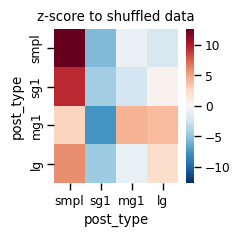

In [227]:

# Define the desired order
order_disp = ['smpl','sg1','mg1','lg']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order_disp, columns=order_disp)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)
plt.title('z-score to shuffled data')
# plt.savefig('/Users/kperks/Downloads/mg_output_conditional_output_analysis.svg', format='svg', transparent=True)

### Larry's svd/pca code cleaned up more for python and my data

In [177]:
from pca import pca as pca_erdogant

In [165]:
def import_dsyn_with_type(syn_file,dtype_file):
    df_syn = pd.read_csv(syn_file)
    df_type = pd.read_csv(dtype_file)
    for i,r in df_syn.iterrows():
        try:
            df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
            df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
        except:
            print(r['pre'],r['post'])
            continue
    
    df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
    df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

    return df_syn

In [166]:
def get_connect(df_syn, columns):# Get unique 'pre' and 'post' values
    '''
    columns: which columns to use for connection counts: ['pre','post'] gets connectivity by cell pairs while ['pre','post_type'] gets connectivity by pre cell - post type relationship
    '''
    df_edges = df_syn[columns].value_counts().reset_index(name='weight')

    m_cells = df_edges[columns[0]].unique()
    n_cells = df_edges[columns[1]].unique()
    
    # Create index mappings
    m_index = {cell: idx for idx, cell in enumerate(m_cells)}
    n_index = {cell: idx for idx, cell in enumerate(n_cells)}
    
    # Initialize the adjacency matrix
    matrix = np.zeros((len(m_cells), len(n_cells)))
    
    # Populate the matrix
    for _, row in df_edges.iterrows():
        i = m_index[row[columns[0]]]
        j = n_index[row[columns[1]]]
        matrix[i, j] = row['weight']

    m_labels=m_cells
    n_labels=n_cells
    return matrix, m_labels, n_labels


def plot_connect(matrix,index_,columns_):
    # Convert matrix to a DataFrame for better visualization
    matrix_df = pd.DataFrame(M, index=index_, columns=columns_) #EX: index_=pre_cells and columns_=post_cells
    
    # Display the result
    sns.heatmap(matrix_df, xticklabels=False, yticklabels=False)

In [167]:
def do_svd(M):
    isfull= M.shape[0] >= M.shape[1]
    S = np.linalg.svd(M, full_matrices=isfull, compute_uv=False)
    S = 100 * S / np.sum(S)
    
    return S

In [168]:
def do_pca(M,n_feat):
    # Apply the fraction total synapses normalization function to each row (each pre cell)

    '''
    pca_result: the data projected into PC space -- ie. scatter(pca_result[:,0],pca_result[:,1]) plots the second principle component against the 3rd to see how the data clusters or not in the space according to other features
    '''
    
    # Perform PCA
    pca_ = PCA(n_components=n_feat)  
    
    pca_result = pca_.fit_transform(M)
    
    # get loadings of dimensions onto each principal component
    loadings = pca_.components_.T

    return pca_, pca_result, loadings

In [169]:
def do_decomposition(df_syn,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff):
    '''
    This function performs both direct svd via numpy.linalg.svd and pca (and svd) via scikit learn decomposition module. scikit pca also returns the svd result so can compare to direct svd via numpy.

    Data can be shuffled and analyzed on each iteration or just analyzed one time. If shuffled across multiple iterations, only the last model fit is returned -- the rest of the results are appended to an array and the mean and std are returned (std = [] if nreps=1)
    
    df_syn: original data in which each row is a single synapse
    columns: which columns to use for connection counts
    nreps: n_reps=1 for data or n_reps>1 for shuffle
    n_feat: number of features to analyze -- only used for pca (svd uses all columns/features)
    which_shuff: whether to shuffle 'synapses' or 'weights'
    how_shuff: only applies if which_shuff=='weights' because it changes whether whole matrix is shuffled around or if shuffles are constrained across rows
    '''
    M_, m_labels, n_labels = get_connect(df_syn, columns)
    
    S = np.zeros((n_reps, n_feat))
    E = np.zeros((n_reps, n_feat))
    E_S = np.zeros((n_reps, n_feat))
    
    for i in range(n_reps):

        if n_reps == 1:
            if norm_row==True:
                M = M_ / M_.sum(axis=1, keepdims=True)
            if norm_row==False:
                M=M_
                
        if n_reps > 1:
            
            if which_shuff=='synapses':
                '''shuffling synapses is more similar to shuffling "all" in connectivity matrix than "rows"'''
                df_syn_shuff = df_syn[columns].apply(np.random.permutation, axis=0)
                M, _, _ = get_connect(df_syn_shuff, columns)
                if norm_row==True:
                    M = M / M.sum(axis=1, keepdims=True)
    
            if which_shuff=='weights':
                # df_syn_shuff = df_syn[columns].apply(np.random.permutation, axis=0)
                # M, _, _ = get_connect(df_syn_shuff, columns)

                if how_shuff=='rows':
                    '''randomize connections across each row (so each m cell has the same number of synapses/weights, but onto different n cells)'''
                    # **NOTE that in Larry analysis, the synapses are totally shuffled across entire matrix so m cells end up with different number of synapses**
                    df = pd.DataFrame(M_)
                    df = df.apply(lambda x: np.random.permutation(x), axis=1, raw=True)
                    M = df.values

                if how_shuff=='all':
                    ''' to do the type of shuffle larry did:'''
                    i_ran = np.random.permutation(np.prod(M_.shape))
                    M = M_.flatten()[i_ran].reshape(M_.shape)
                
                if norm_row==True:
                    M = M / M.sum(axis=1, keepdims=True)
    
        scaler = StandardScaler()
        M = scaler.fit_transform(M)
    
        S_ = do_svd(M)
        S[i, :] = S_

        pca_, pca_result, loadings = do_pca(M,n_feat)
        E[i,:]= pca_.explained_variance_ratio_

        E_S_ =  pca_.singular_values_ 
        E_S[i,:]= 100 * E_S_ / np.sum(E_S_)
        
    sigS = []
    if n_reps>1:
        sigS = np.std(S, axis=0)
    S = np.mean(S, axis=0)     
    
    sigE = []
    if n_reps>1:
        sigE = np.std(E, axis=0)
    E = np.mean(E, axis=0)   

    sigE_S = []
    if n_reps>1:
        sigE_S = np.std(E_S, axis=0)
    E_S = np.mean(E_S, axis=0)   

    return m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings

#### shuffle SYNAPSES with features post TYPE

In [162]:
# post-synaptic labeling
dsource = 'pre_type'
idsource = 'pre'
dtarget = 'post_type'
idtarget = 'post'

# Desired source_types and order
source_types_order = ['grc'] #['mg1','lg', 'mg2','lf'] #['mg1','mg2'] #
# Desired target_types and order
target_types_order = ['smpl','sg1', 'mg1','lg']  #['aff','smpl','sg1','grc','sg2'] #['mg1','lg', 'mg2','lf'] #

In [163]:
mask = df_syn[dsource].isin(source_types_order) & df_syn[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn[mask]

In [170]:
columns=['pre','post_type']
norm_row=True
n_feat=np.min([len(df_syn_data[columns[0]].unique()),len(df_syn_data[columns[1]].unique())])
which_shuff='synapses'
how_shuff=''
n_reps=1
m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

n_reps=100
m_labels, n_labels, E_ran, sigE, E_S_ran, sigE_S, S_ran, sigS, pca_result_ran, loadings_ran = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

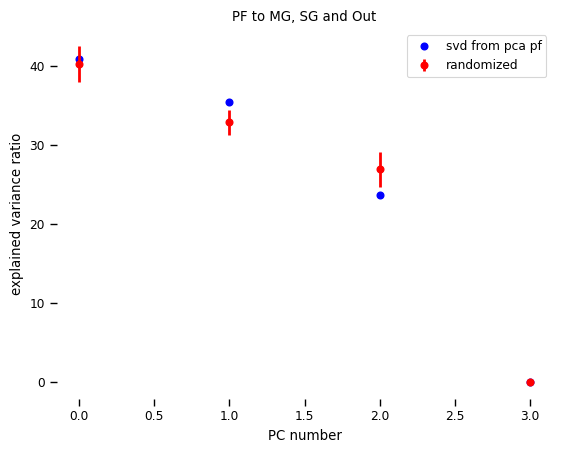

In [171]:

plt.figure()
plt.plot(range(len(E_S)),E_S, 'bo', linewidth=2, label='svd from pca pf')
plt.errorbar(range(len(E_S_ran)),E_S_ran,yerr=sigE_S,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

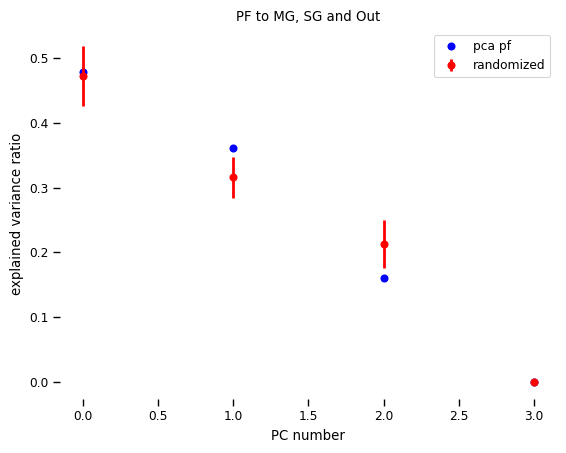

In [172]:

plt.figure()
plt.plot(range(len(E)),E, 'bo', linewidth=2, label='pca pf')
plt.errorbar(range(len(E_ran)),E_ran,yerr=sigE,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

In [173]:
M, m_labels, n_labels = get_connect(df_syn_data,columns)
n_syn = M.sum(axis=1, keepdims=True)
# if norm_row==True:
M = M / M.sum(axis=1, keepdims=True)

df_result = pd.DataFrame(M, index=m_labels, columns=n_labels)
df_result['n_syn']=n_syn

# df_result = deepcopy(df_syn_data)
# Add PCA results to the DataFrame
for i in range(n_feat):
    df_result[str(i)] = pca_result[:, i]

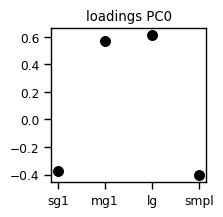

In [174]:
hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(n_labels,[l[0] for l in loadings],color = 'black',s=50)
plt.title('loadings PC0');

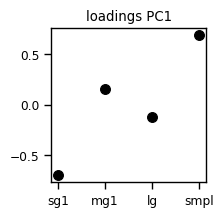

In [175]:
hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(n_labels,[l[1] for l in loadings],color = 'black',s=50)
plt.title('loadings PC1');

In [178]:
M, m_labels, n_labels = get_connect(df_syn_data,columns)
n_syn = M.sum(axis=1, keepdims=True)
# if norm_row==True:
M = M / M.sum(axis=1, keepdims=True)

scaler = StandardScaler()
M = scaler.fit_transform(M)
norm_df = pd.DataFrame(M, index=m_labels, columns=n_labels)

model = pca_erdogant()

results = model.fit_transform(norm_df);

# # Add PCA results to the DataFrame
# for i in range(n_feat):
#     df_result[str(i)] = pca_result[:, i]

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [4] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'3 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (47.8% expl.var)', ylabel='PC2 (36.0% expl.var)'>)

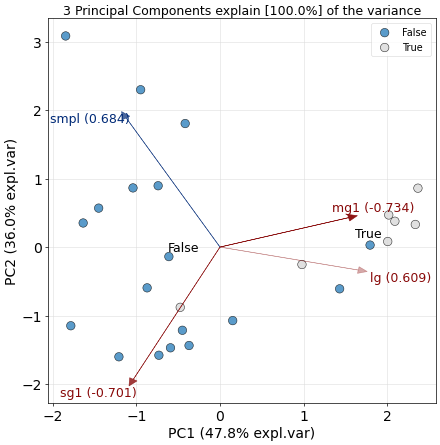

In [179]:
X_feat = norm_df['mg1'].values>np.mean(norm_df['mg1'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg2.svg', format='svg', transparent=True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'3 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (47.8% expl.var)', ylabel='PC2 (36.0% expl.var)'>)

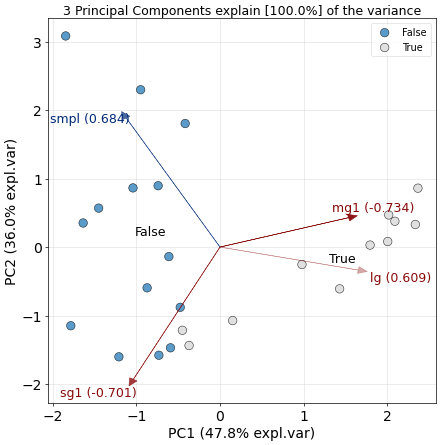

In [181]:
X_feat = norm_df['lg'].values>np.mean(norm_df['lg'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg2.svg', format='svg', transparent=True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'3 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (47.8% expl.var)', ylabel='PC2 (36.0% expl.var)'>)

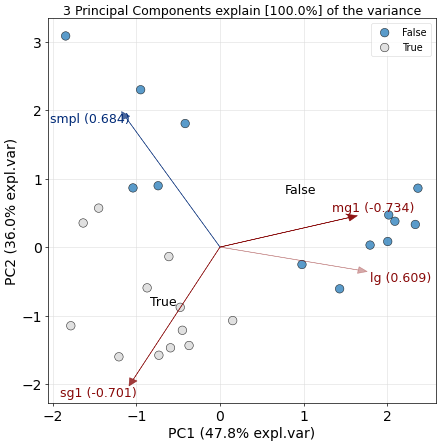

In [180]:
X_feat = norm_df['sg1'].values>np.mean(norm_df['sg1'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg2.svg', format='svg', transparent=True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'3 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (47.8% expl.var)', ylabel='PC2 (36.0% expl.var)'>)

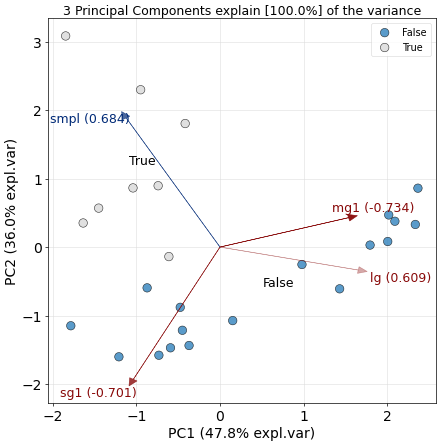

In [182]:
X_feat = norm_df['smpl'].values>np.mean(norm_df['smpl'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg2.svg', format='svg', transparent=True)

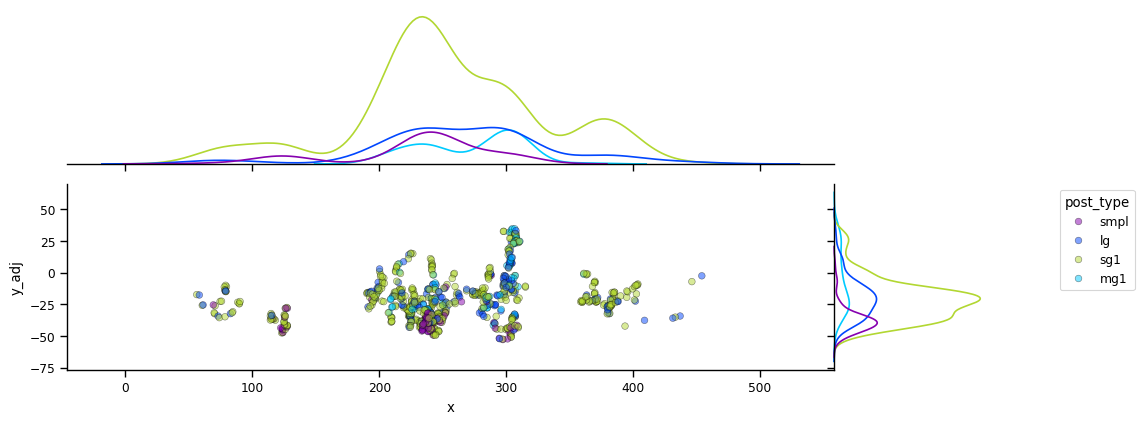

In [158]:

g = sns.jointplot(data=df_syn[df_syn['post_type'].isin(['smpl','sg1','mg1','lg'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="post_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

<AxesSubplot:xlabel='Density', ylabel='y_adj'>

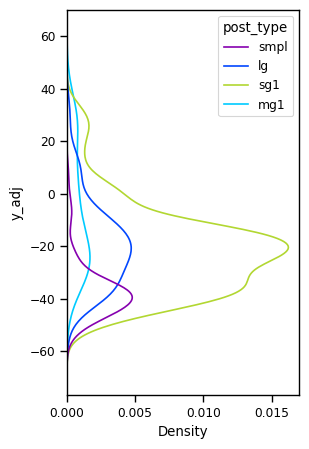

In [160]:
hfig,ax = plt.subplots(1,figsize=(3,5))
sns.kdeplot(data=df_syn[df_syn['post_type'].isin(['smpl','sg1','mg1','lg'])],
           y='y_adj', hue="post_type",palette = syn_colors)

## find cells annotated

In [26]:
df_edges.head()

,post,pre,pre_type,post_type,weight
0,394470350,668081112,aff,sgx2,30
1,481412554,668081112,aff,grc,27
2,482680782,60192229,aff,grc,23
3,389891998,668081112,aff,sg2,23
4,483689146,668081112,aff,grc,22


In [28]:
df_edges[df_edges['post_type'].isin(['sg2'])]['post'].unique()

array([389891998,  50786130, 393433572, 306461085, 647514445, 218095913,
       394423863, 477962738, 395507584, 473491444])

## clustermap

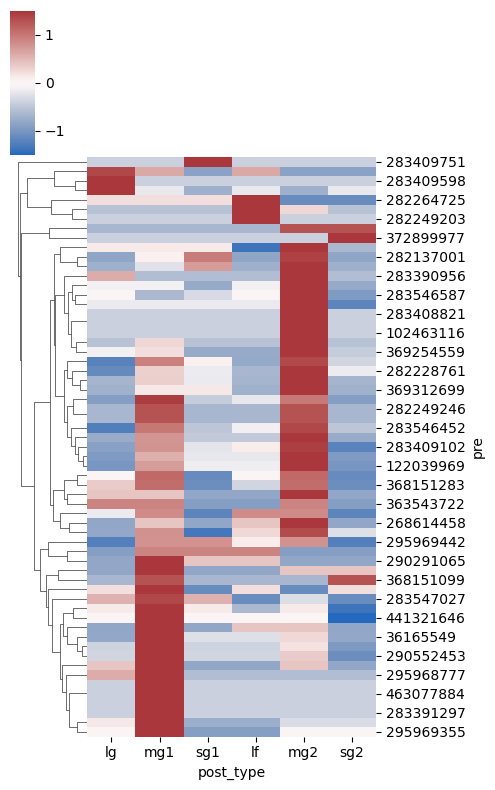

In [180]:

# sns.set(font_scale=1.4)
sns.clustermap(data=df_map,z_score=0,cmap='vlag',col_cluster=False, vmin=-1.5, vmax=1.5,figsize=(5,8))

<Axes: xlabel='lf', ylabel='mg1'>

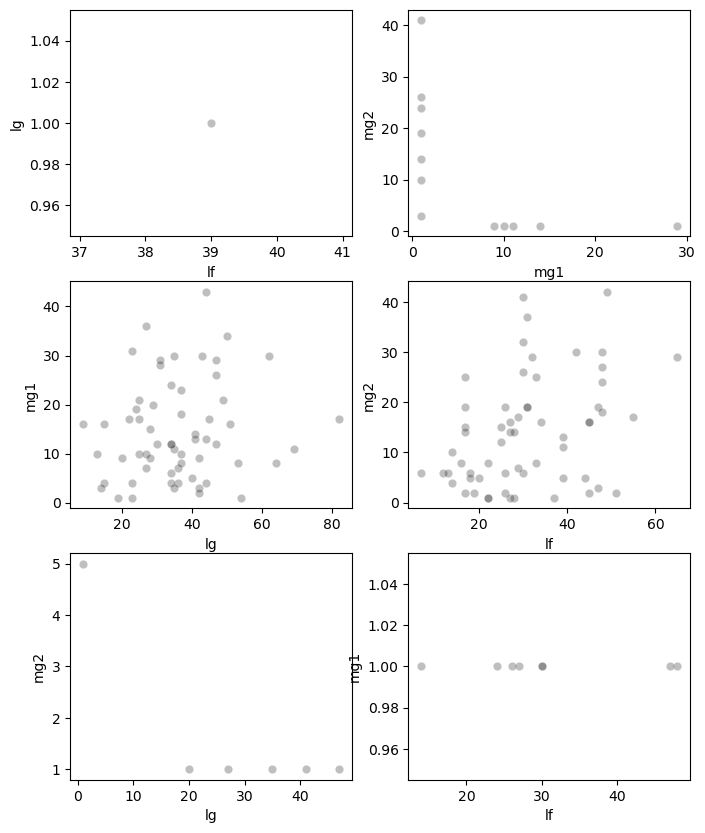

In [163]:
hfig,ax = plt.subplots(3,2,figsize=(8,10))
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['lf'] != 0)], x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['mg1'] != 0)& (df_map['mg2'] != 0)], x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg1'] != 0)], x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg2'] != 0)], x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg2'] != 0)], x = 'lg', y = 'mg2', ax = ax[2][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg1'] != 0)], x = 'lf', y = 'mg1', ax = ax[2][1],alpha = 0.25,color = 'black')